In [32]:
import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [33]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [34]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [35]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (96, 96))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (96, 96))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
TRAIN_LENGHT = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGHT // BATCH_SIZE

In [37]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [38]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [39]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [40]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title = ["Imagen de entrada", "Mascara", "Prediccion"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

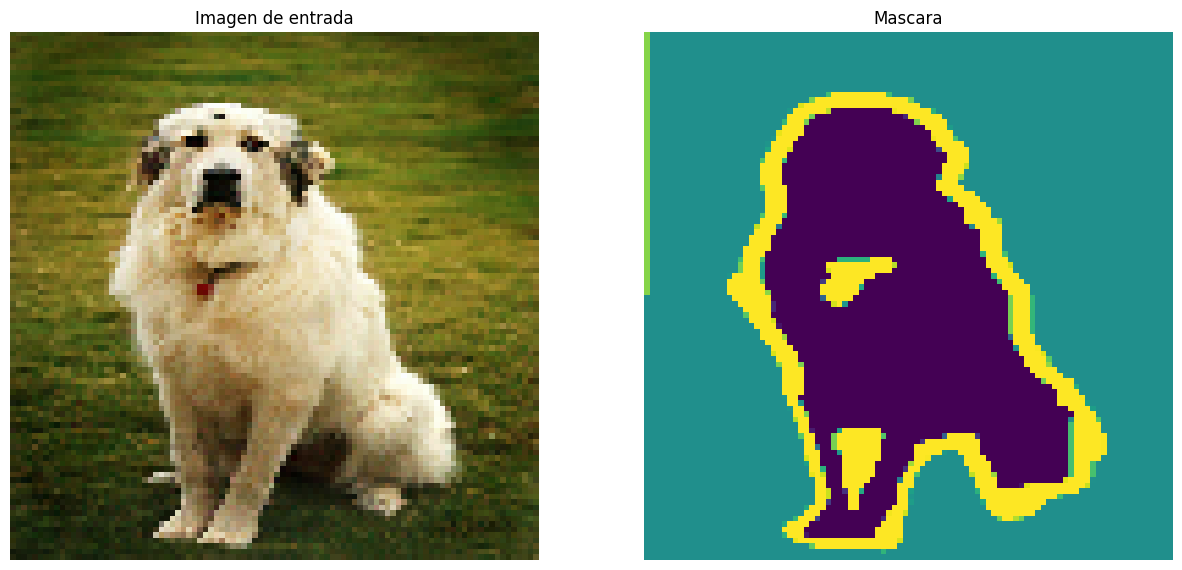

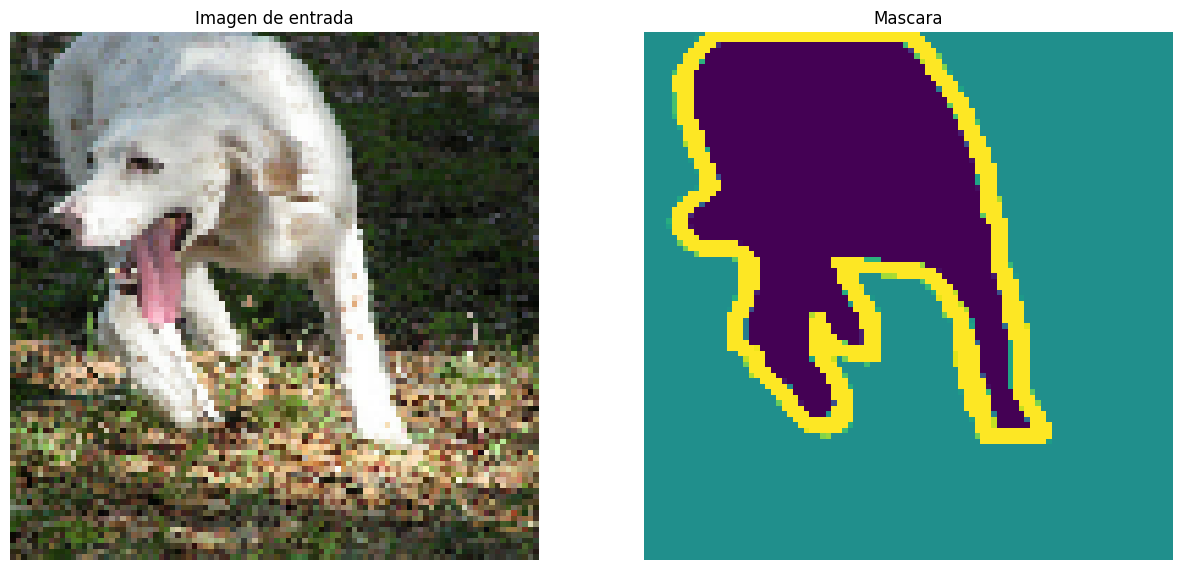

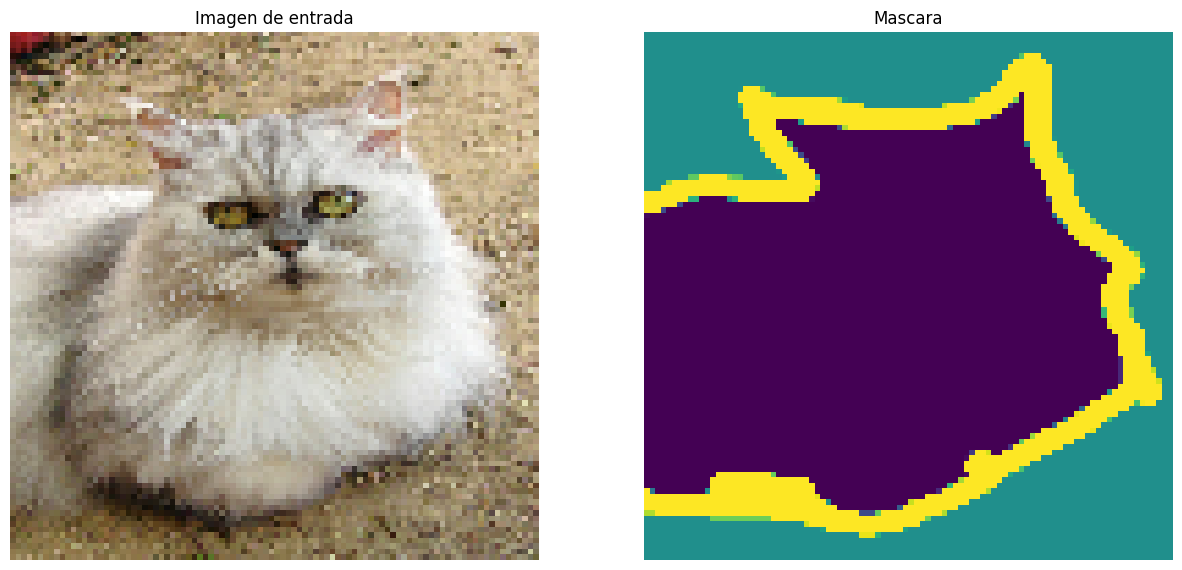

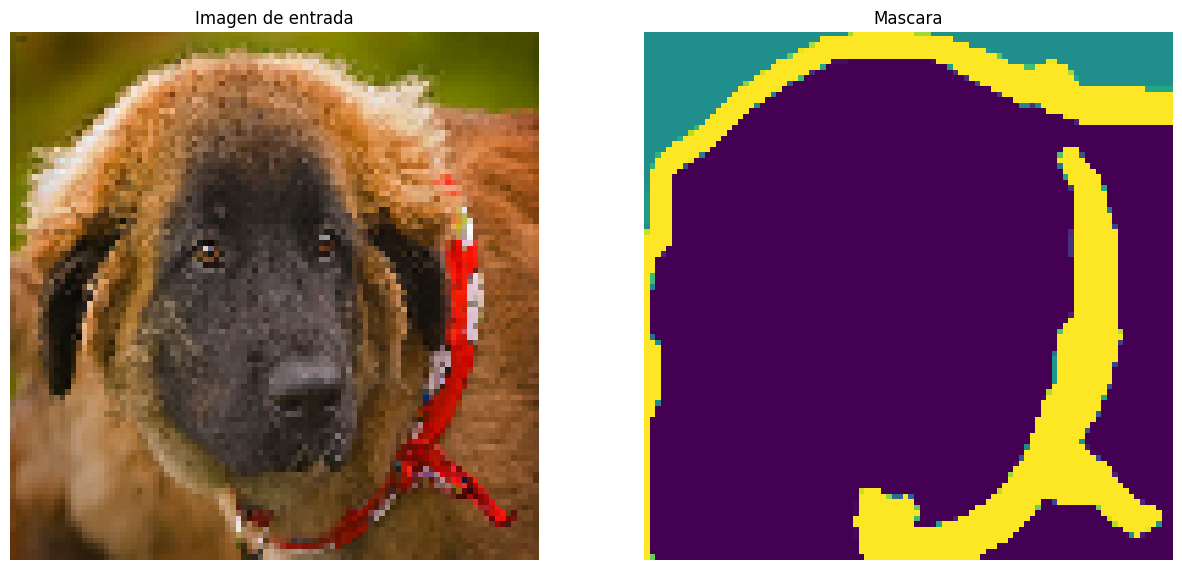

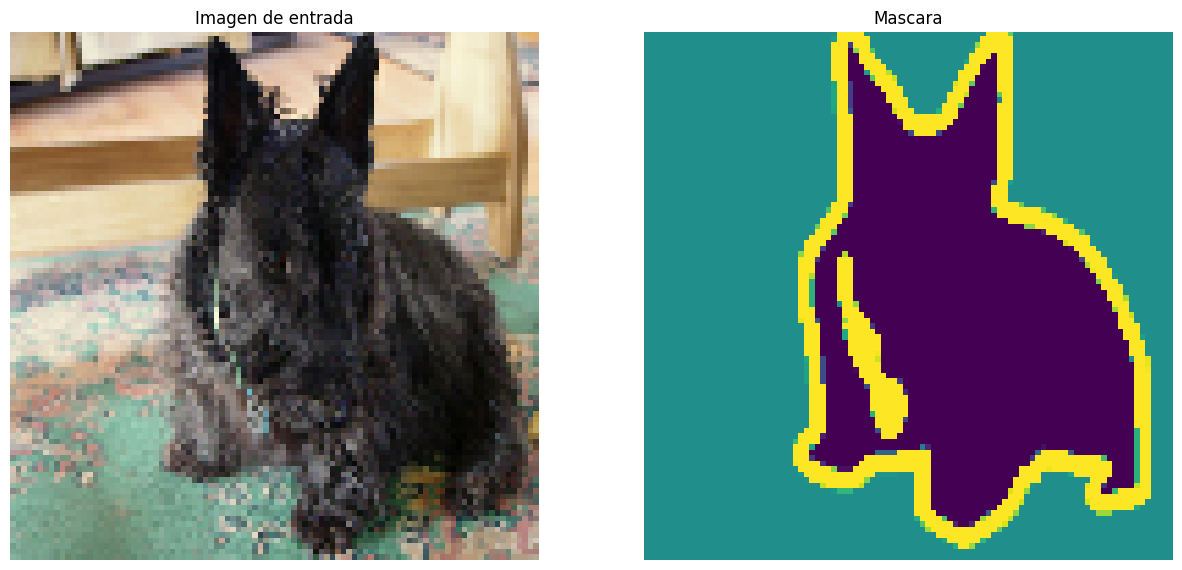

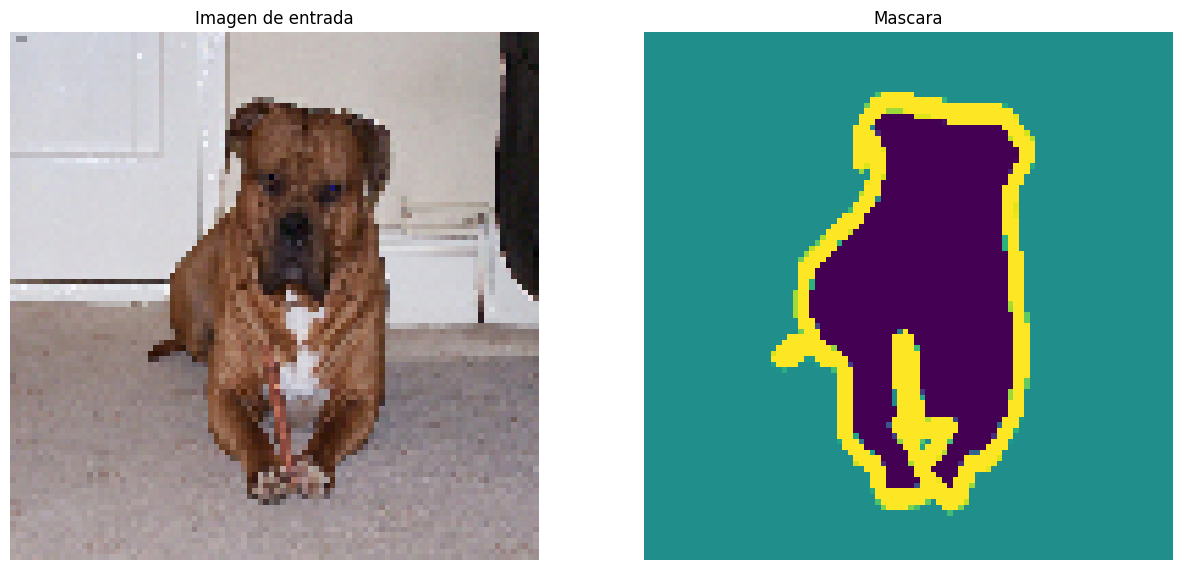

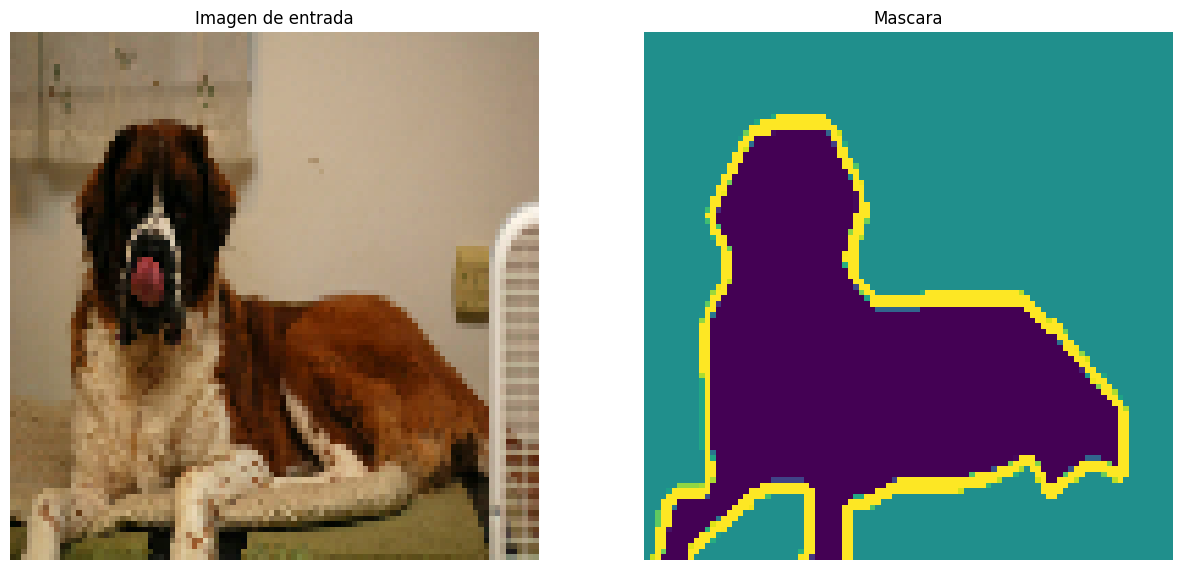

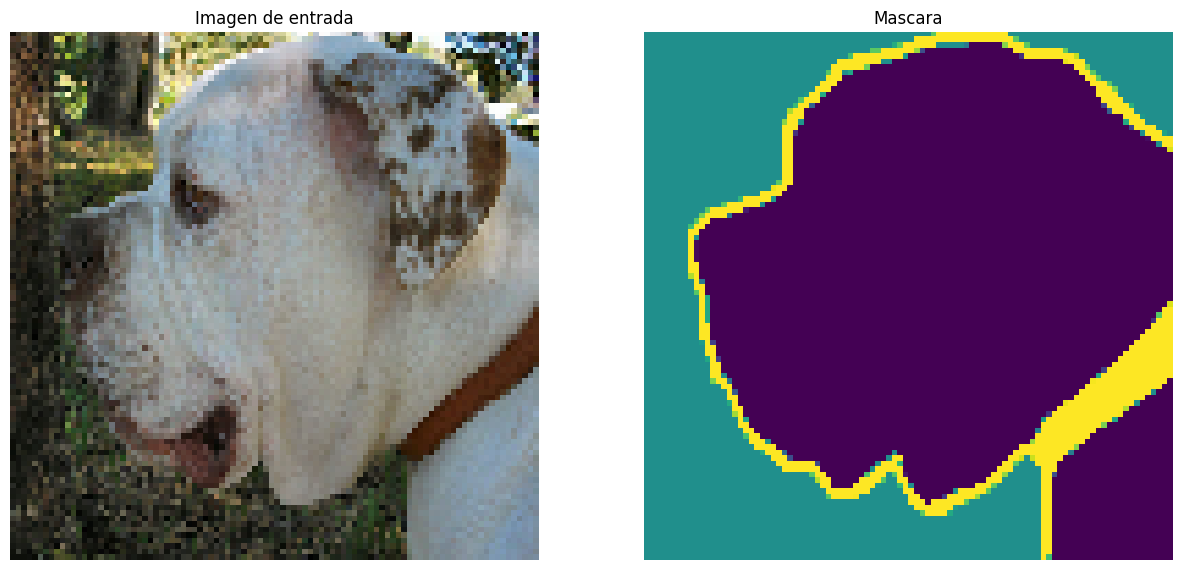

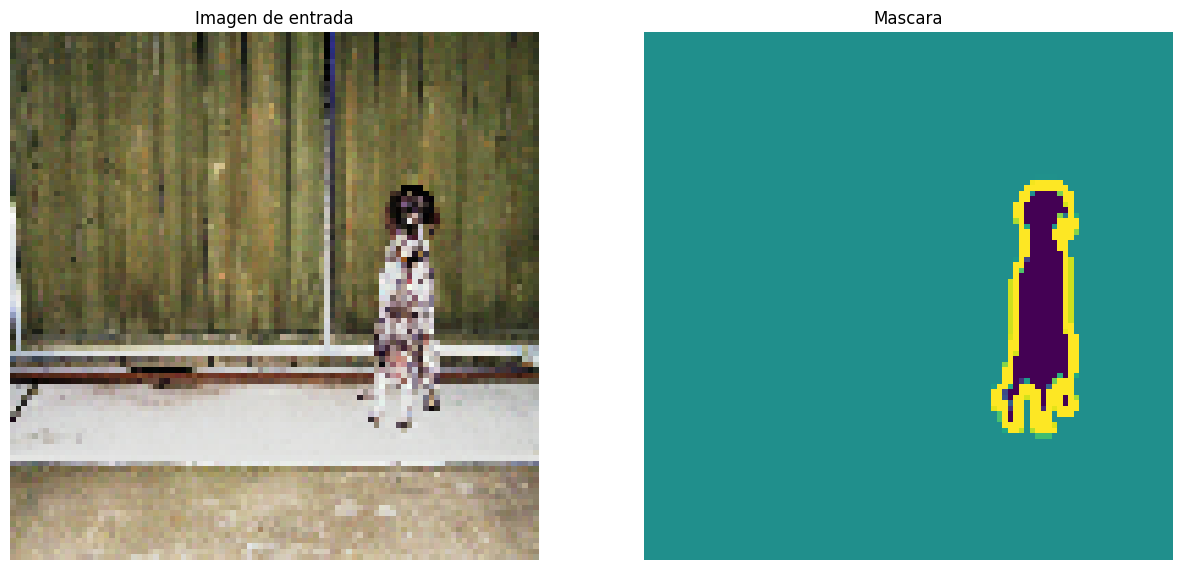

In [41]:
for images, masks in train_batches.take(9):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [42]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[96, 96, 3], include_top=False)

In [43]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

In [44]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [45]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [46]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[96, 96, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])


    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding="same"
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x) 

In [47]:
OUTPUT_CHANNELS = 3

model = unet_model(OUTPUT_CHANNELS)

model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [48]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [49]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           [(None, 48, 48, 96)  1841984     ['input_4[0][0]']                
                                , (None, 24, 24, 14                                               
                                4),                                                               
                                 (None, 12, 12, 192                                               
                                ),                                                                
                                 (None, 6, 6, 576),                                         

In [50]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 858ms/step


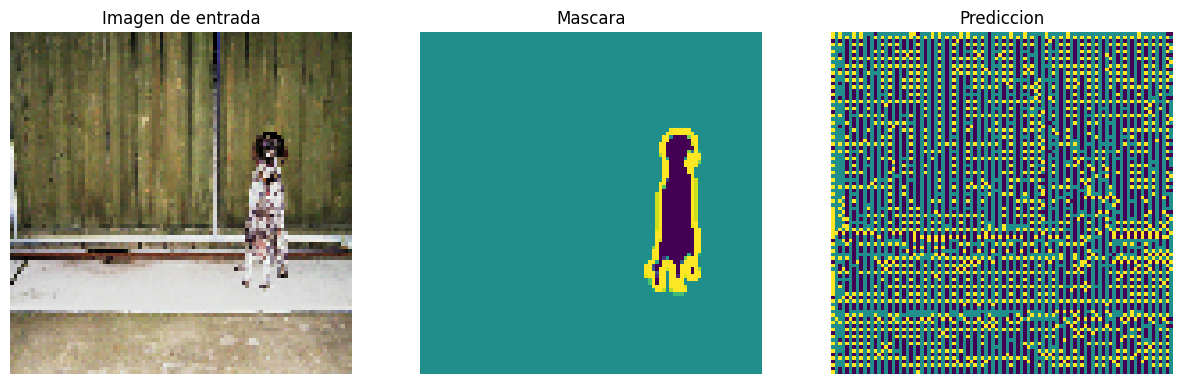

In [51]:
show_predictions()

In [52]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [53]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

Epoch 1/50
1/1 [==============================] - 0s 120ms/steposs: 0.8773 - accuracy: 0.61


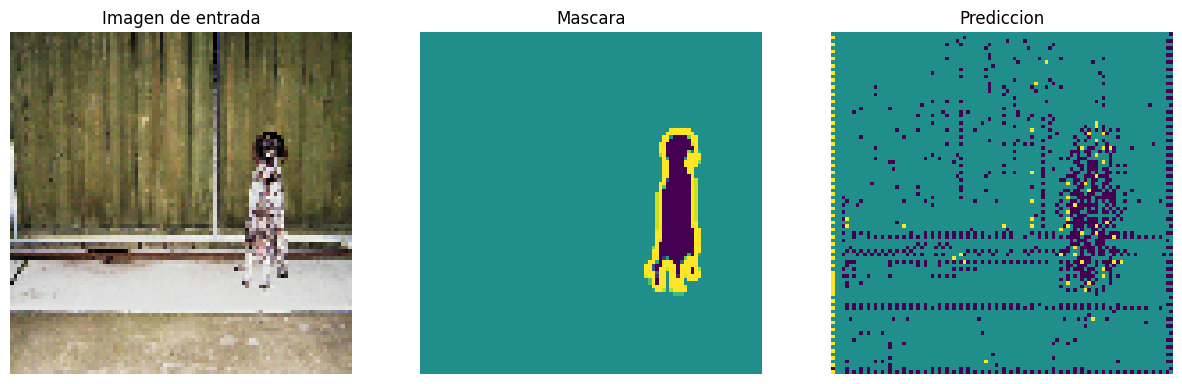


Sample Prediction after epoch 1

57/57 [==============================] - 9s 102ms/step - loss: 0.8773 - accuracy: 0.6126 - val_loss: 0.8397 - val_accuracy: 0.6438
Epoch 2/50
1/1 [==============================] - 0s 100ms/steposs: 0.6207 - accuracy: 0.76


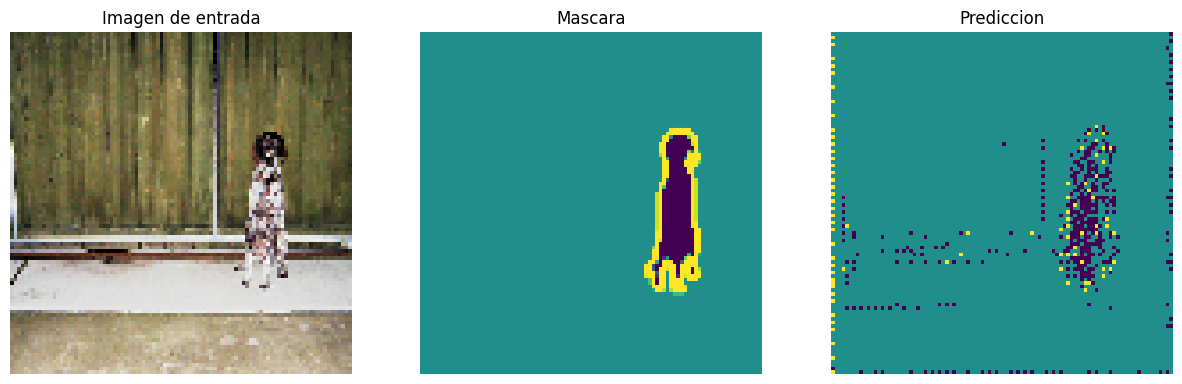


Sample Prediction after epoch 2

57/57 [==============================] - 4s 74ms/step - loss: 0.6193 - accuracy: 0.7680 - val_loss: 0.6804 - val_accuracy: 0.7455
Epoch 3/50
1/1 [==============================] - 0s 98ms/steploss: 0.5182 - accuracy: 0.81


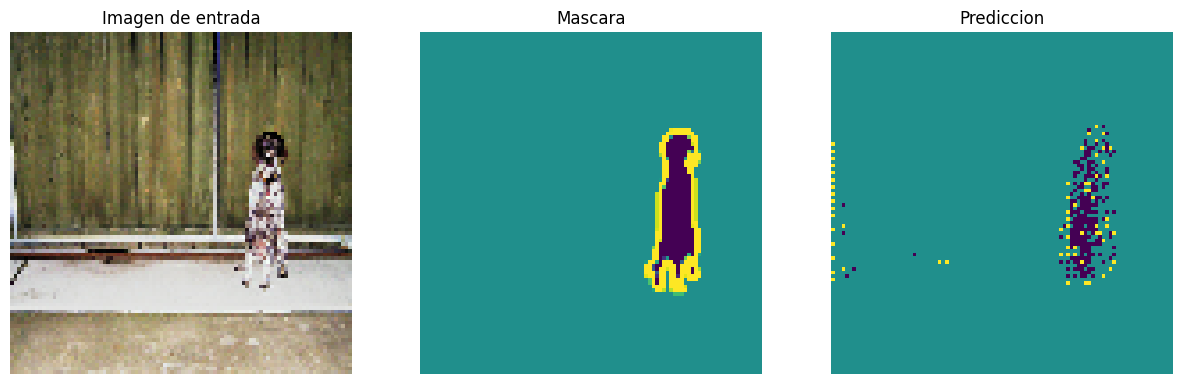


Sample Prediction after epoch 3

57/57 [==============================] - 4s 69ms/step - loss: 0.5182 - accuracy: 0.8117 - val_loss: 0.5696 - val_accuracy: 0.7893
Epoch 4/50
1/1 [==============================] - 0s 99ms/steploss: 0.4578 - accuracy: 0.82


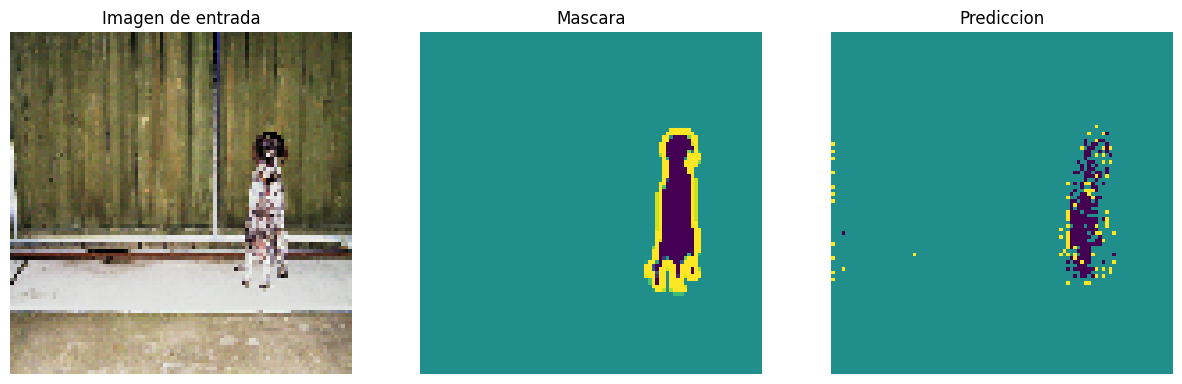


Sample Prediction after epoch 4

57/57 [==============================] - 4s 68ms/step - loss: 0.4575 - accuracy: 0.8293 - val_loss: 0.4925 - val_accuracy: 0.8153
Epoch 5/50
1/1 [==============================] - 0s 99ms/steploss: 0.4188 - accuracy: 0.83


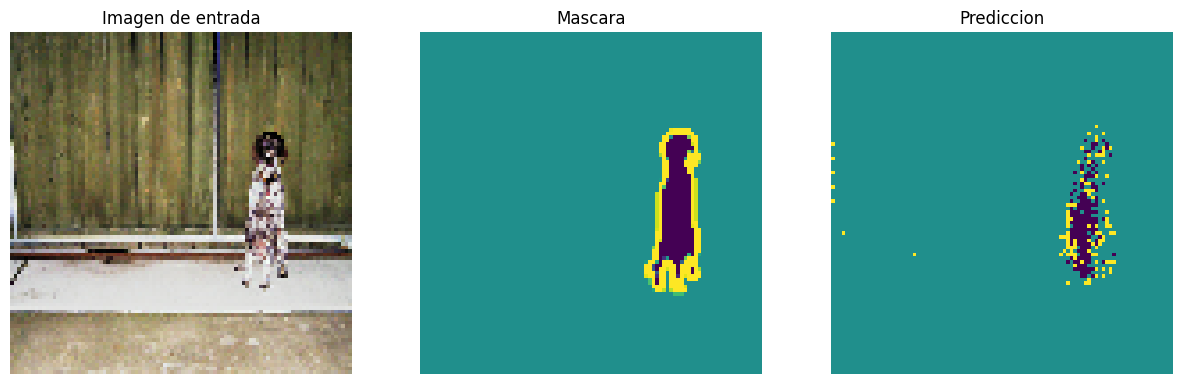


Sample Prediction after epoch 5

57/57 [==============================] - 4s 67ms/step - loss: 0.4188 - accuracy: 0.8395 - val_loss: 0.4465 - val_accuracy: 0.8283
Epoch 6/50
1/1 [==============================] - 0s 93ms/steploss: 0.3888 - accuracy: 0.84


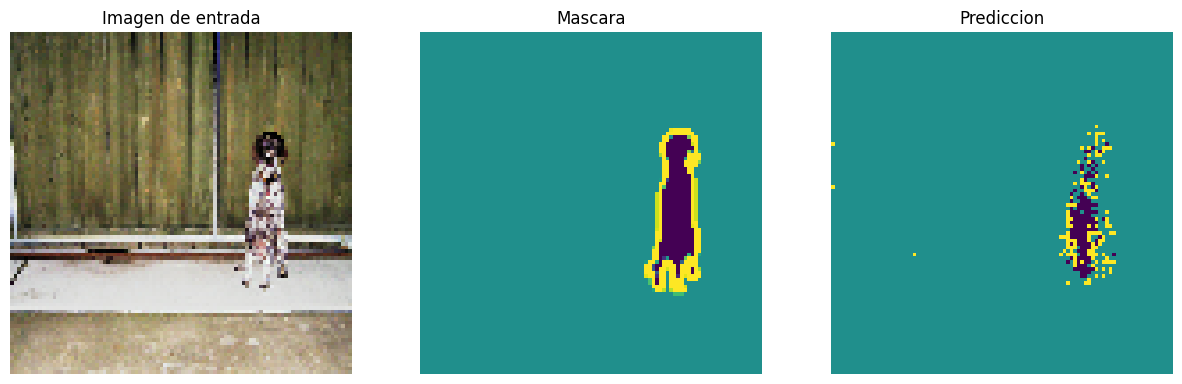


Sample Prediction after epoch 6

57/57 [==============================] - 4s 68ms/step - loss: 0.3888 - accuracy: 0.8488 - val_loss: 0.4202 - val_accuracy: 0.8370
Epoch 7/50
1/1 [==============================] - 0s 102ms/steposs: 0.3690 - accuracy: 0.85


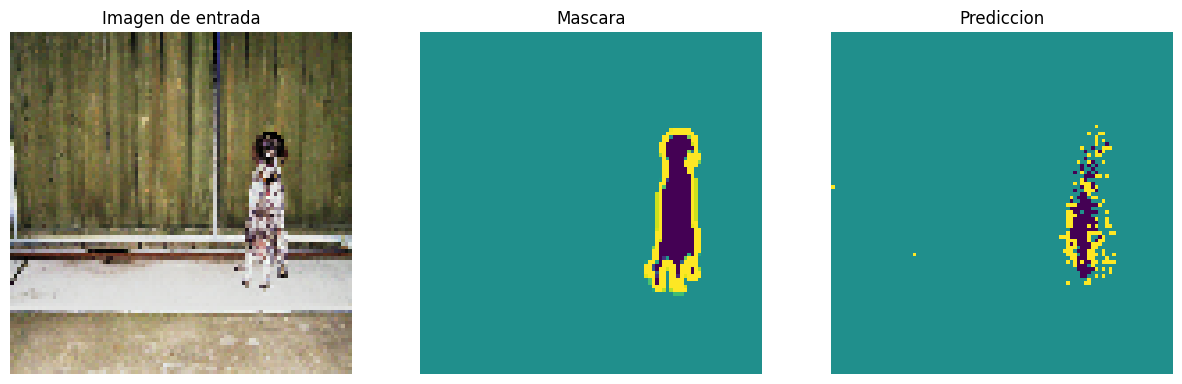


Sample Prediction after epoch 7

57/57 [==============================] - 4s 68ms/step - loss: 0.3690 - accuracy: 0.8553 - val_loss: 0.4019 - val_accuracy: 0.8417
Epoch 8/50
1/1 [==============================] - 0s 100ms/steposs: 0.3508 - accuracy: 0.86


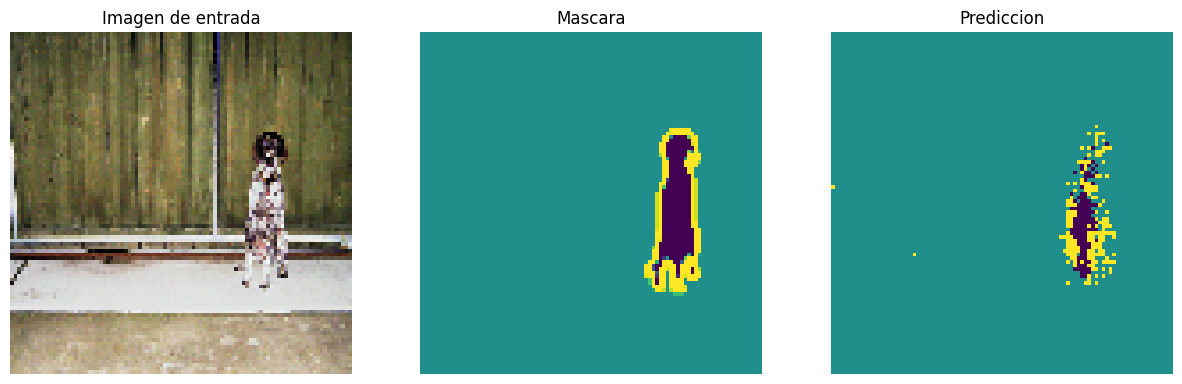


Sample Prediction after epoch 8

57/57 [==============================] - 4s 68ms/step - loss: 0.3508 - accuracy: 0.8619 - val_loss: 0.3867 - val_accuracy: 0.8484
Epoch 9/50
1/1 [==============================] - 0s 102ms/steposs: 0.3343 - accuracy: 0.86


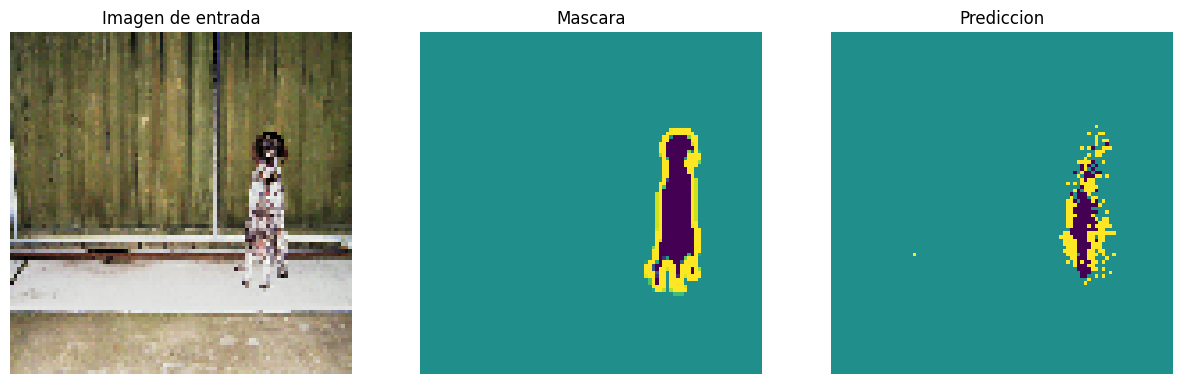


Sample Prediction after epoch 9

57/57 [==============================] - 4s 68ms/step - loss: 0.3343 - accuracy: 0.8677 - val_loss: 0.3740 - val_accuracy: 0.8514
Epoch 10/50
1/1 [==============================] - 0s 109ms/steposs: 0.3238 - accuracy: 0.87


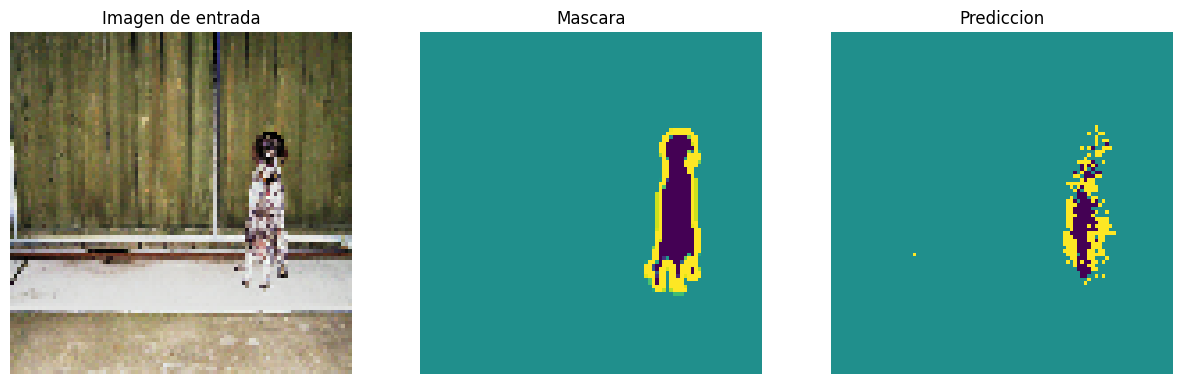


Sample Prediction after epoch 10

57/57 [==============================] - 4s 68ms/step - loss: 0.3238 - accuracy: 0.8712 - val_loss: 0.3619 - val_accuracy: 0.8564
Epoch 11/50
1/1 [==============================] - 0s 100ms/steposs: 0.3131 - accuracy: 0.87


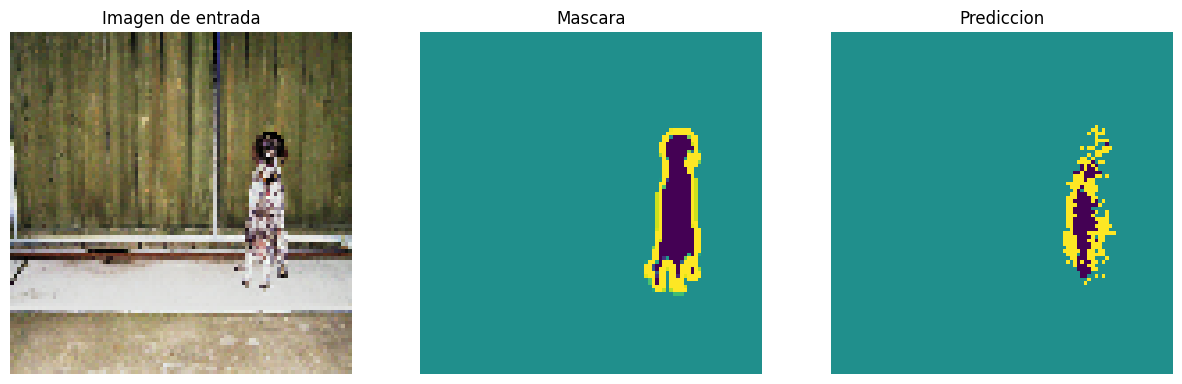


Sample Prediction after epoch 11

57/57 [==============================] - 4s 68ms/step - loss: 0.3131 - accuracy: 0.8749 - val_loss: 0.3506 - val_accuracy: 0.8608
Epoch 12/50
1/1 [==============================] - 0s 102ms/steposs: 0.3036 - accuracy: 0.87


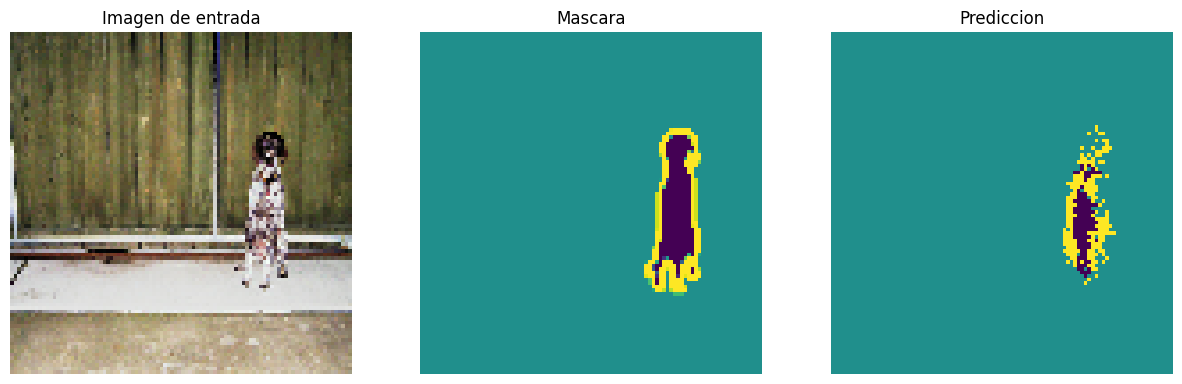


Sample Prediction after epoch 12

57/57 [==============================] - 4s 69ms/step - loss: 0.3036 - accuracy: 0.8781 - val_loss: 0.3497 - val_accuracy: 0.8604
Epoch 13/50
1/1 [==============================] - 0s 101ms/steposs: 0.2943 - accuracy: 0.88


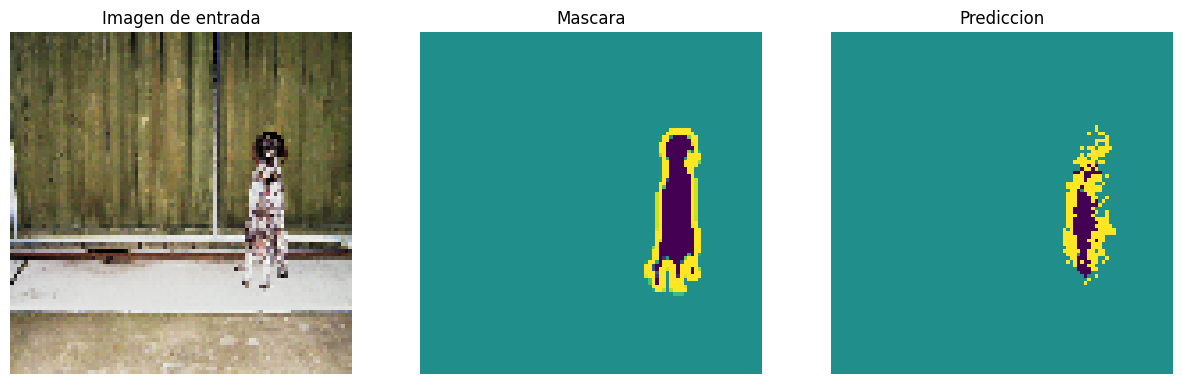


Sample Prediction after epoch 13

57/57 [==============================] - 4s 68ms/step - loss: 0.2943 - accuracy: 0.8814 - val_loss: 0.3410 - val_accuracy: 0.8634
Epoch 14/50
1/1 [==============================] - 0s 100ms/steposs: 0.2845 - accuracy: 0.88


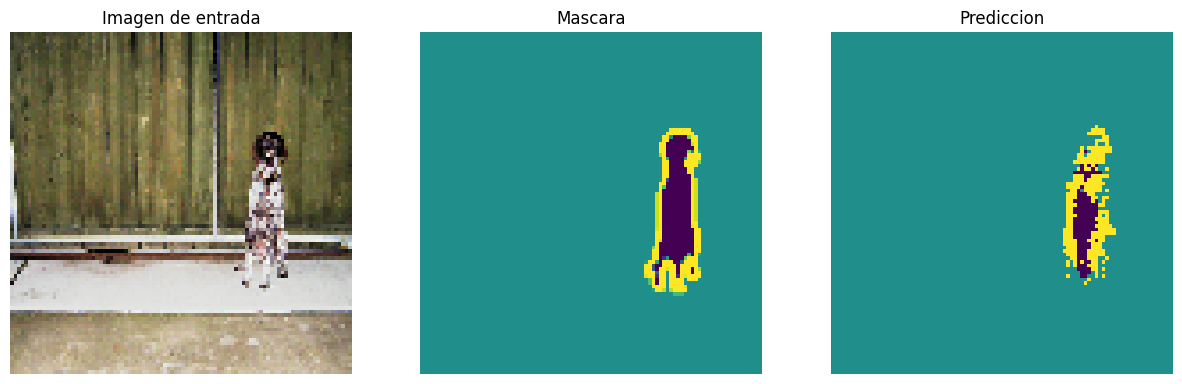


Sample Prediction after epoch 14

57/57 [==============================] - 4s 68ms/step - loss: 0.2845 - accuracy: 0.8851 - val_loss: 0.3306 - val_accuracy: 0.8676
Epoch 15/50
1/1 [==============================] - 0s 105ms/steposs: 0.2791 - accuracy: 0.88


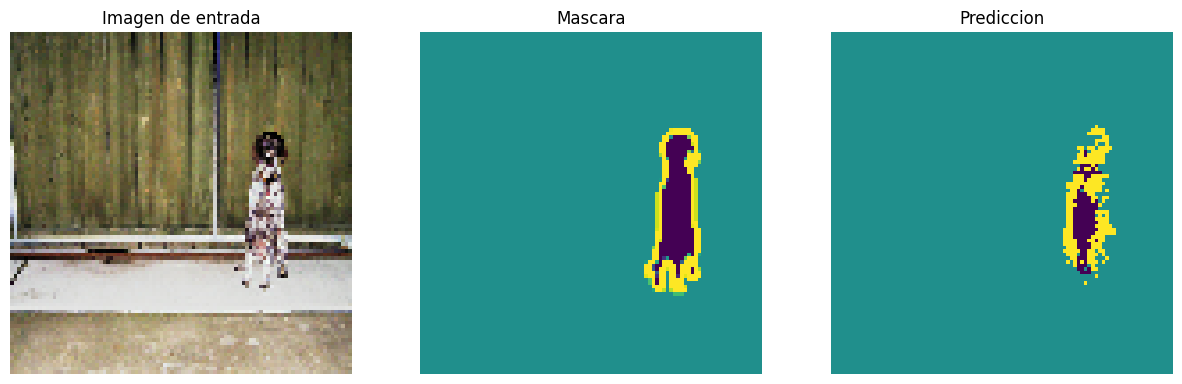


Sample Prediction after epoch 15

57/57 [==============================] - 4s 69ms/step - loss: 0.2789 - accuracy: 0.8868 - val_loss: 0.3296 - val_accuracy: 0.8677
Epoch 16/50
1/1 [==============================] - 0s 104ms/steposs: 0.2724 - accuracy: 0.88


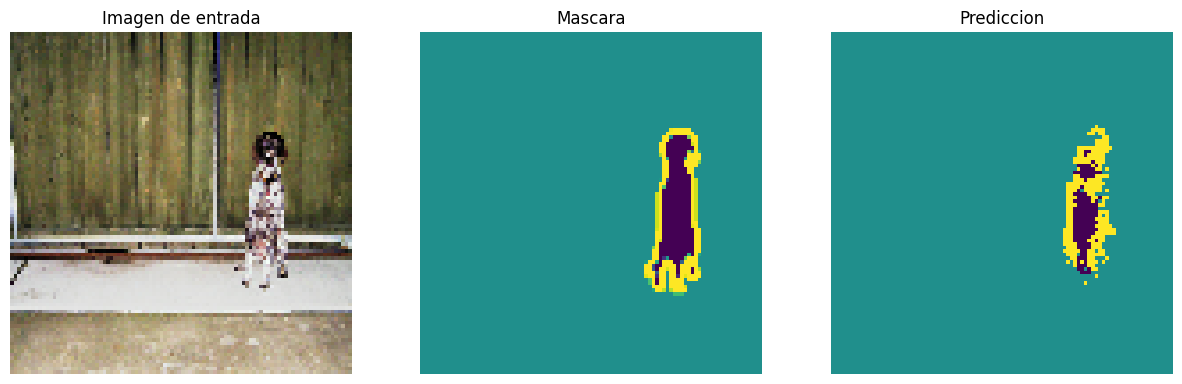


Sample Prediction after epoch 16

57/57 [==============================] - 4s 68ms/step - loss: 0.2724 - accuracy: 0.8889 - val_loss: 0.3265 - val_accuracy: 0.8684
Epoch 17/50
1/1 [==============================] - 0s 104ms/steposs: 0.2658 - accuracy: 0.89


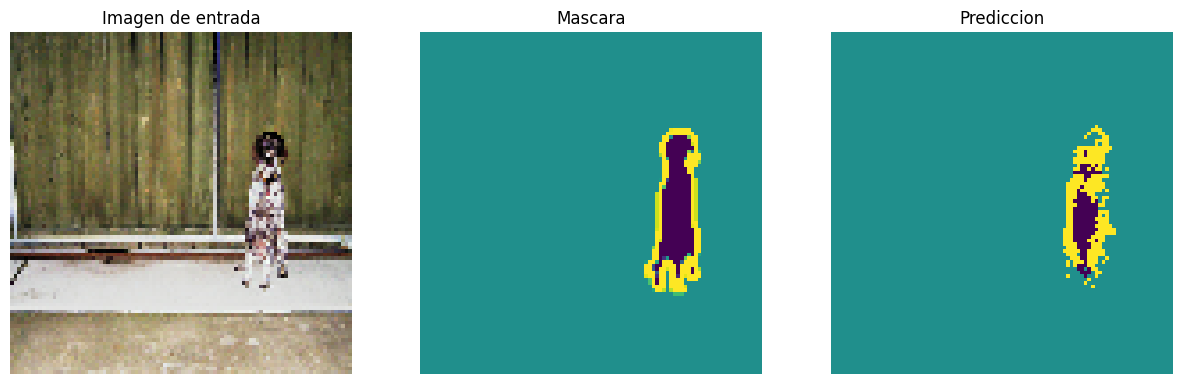


Sample Prediction after epoch 17

57/57 [==============================] - 4s 67ms/step - loss: 0.2658 - accuracy: 0.8913 - val_loss: 0.3193 - val_accuracy: 0.8718
Epoch 18/50
1/1 [==============================] - 0s 106ms/steposs: 0.2581 - accuracy: 0.89


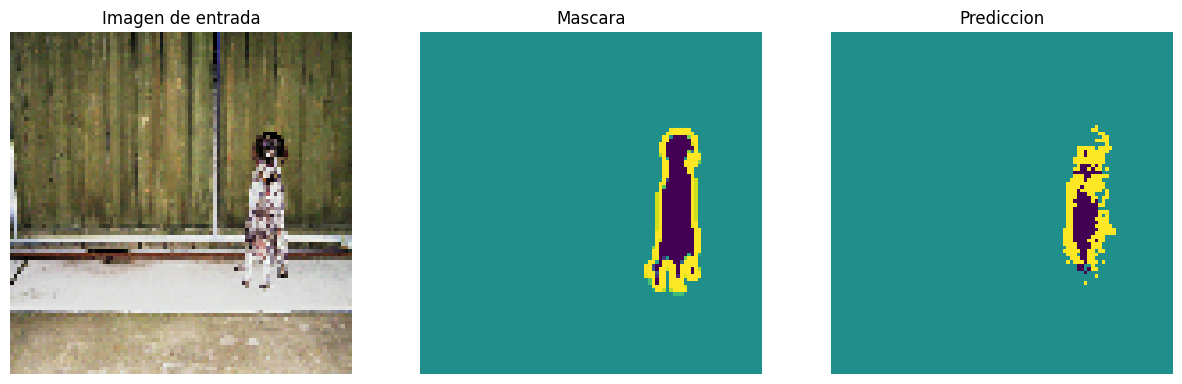


Sample Prediction after epoch 18

57/57 [==============================] - 4s 68ms/step - loss: 0.2581 - accuracy: 0.8940 - val_loss: 0.3220 - val_accuracy: 0.8702
Epoch 19/50
1/1 [==============================] - 0s 104ms/steposs: 0.2536 - accuracy: 0.89


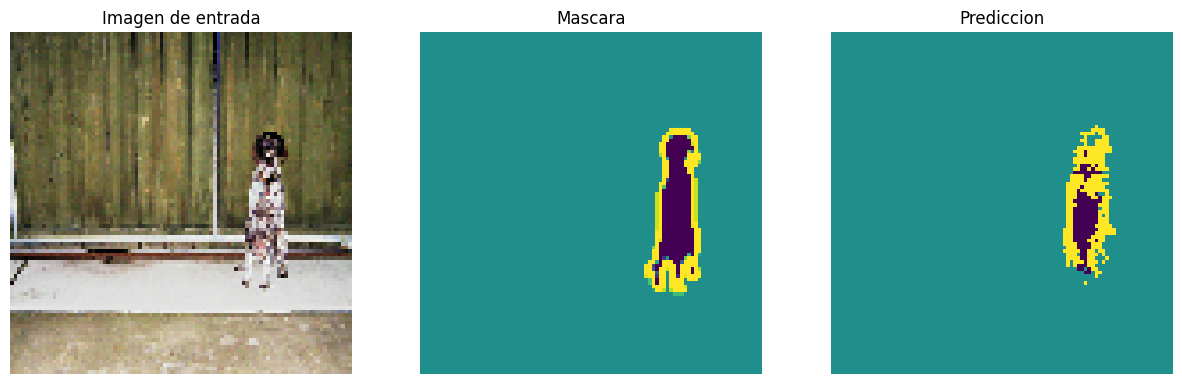


Sample Prediction after epoch 19

57/57 [==============================] - 4s 67ms/step - loss: 0.2536 - accuracy: 0.8955 - val_loss: 0.3178 - val_accuracy: 0.8725
Epoch 20/50
1/1 [==============================] - 0s 101ms/steposs: 0.2453 - accuracy: 0.89


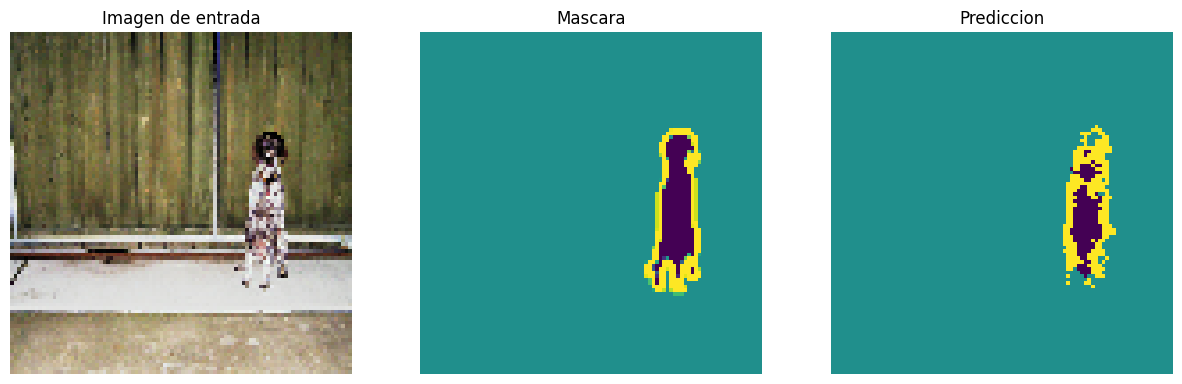


Sample Prediction after epoch 20

57/57 [==============================] - 4s 68ms/step - loss: 0.2453 - accuracy: 0.8986 - val_loss: 0.3144 - val_accuracy: 0.8742
Epoch 21/50
1/1 [==============================] - 0s 100ms/steposs: 0.2423 - accuracy: 0.89


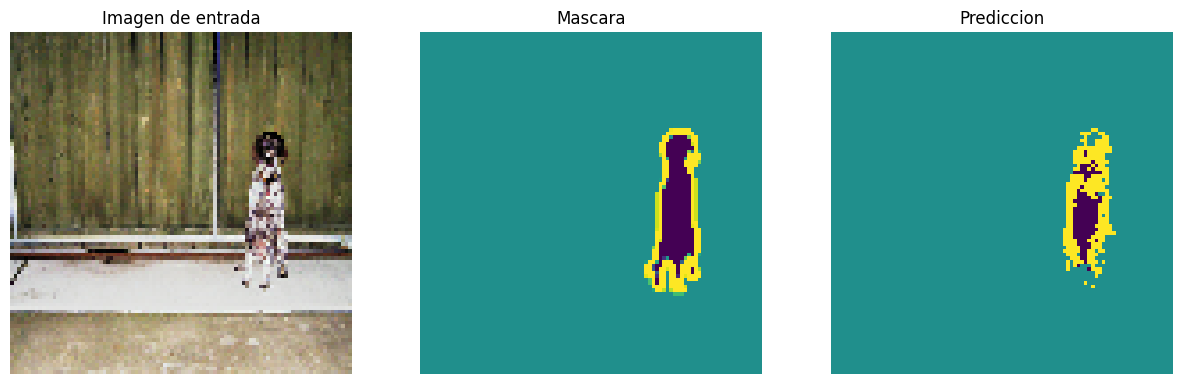


Sample Prediction after epoch 21

57/57 [==============================] - 4s 70ms/step - loss: 0.2423 - accuracy: 0.8995 - val_loss: 0.3158 - val_accuracy: 0.8733
Epoch 22/50
1/1 [==============================] - 0s 109ms/steposs: 0.2364 - accuracy: 0.90


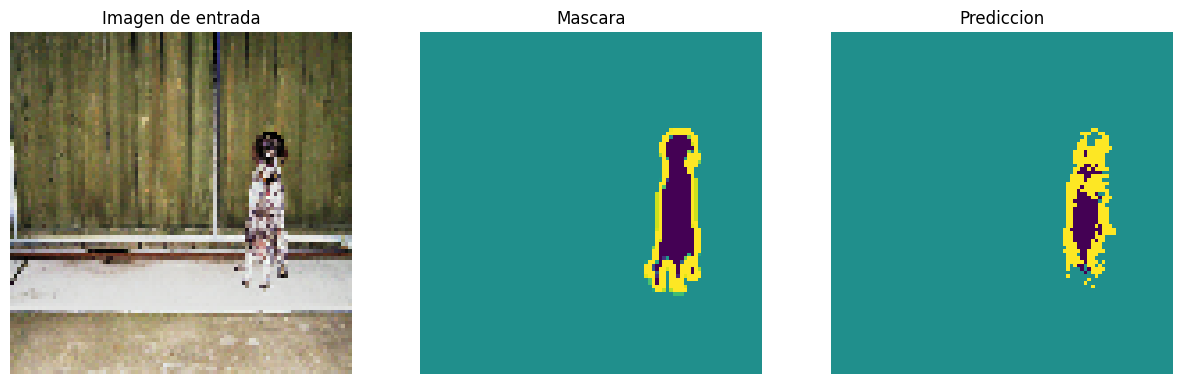


Sample Prediction after epoch 22

57/57 [==============================] - 4s 68ms/step - loss: 0.2364 - accuracy: 0.9016 - val_loss: 0.3190 - val_accuracy: 0.8723
Epoch 23/50
1/1 [==============================] - 0s 100ms/steposs: 0.2305 - accuracy: 0.90


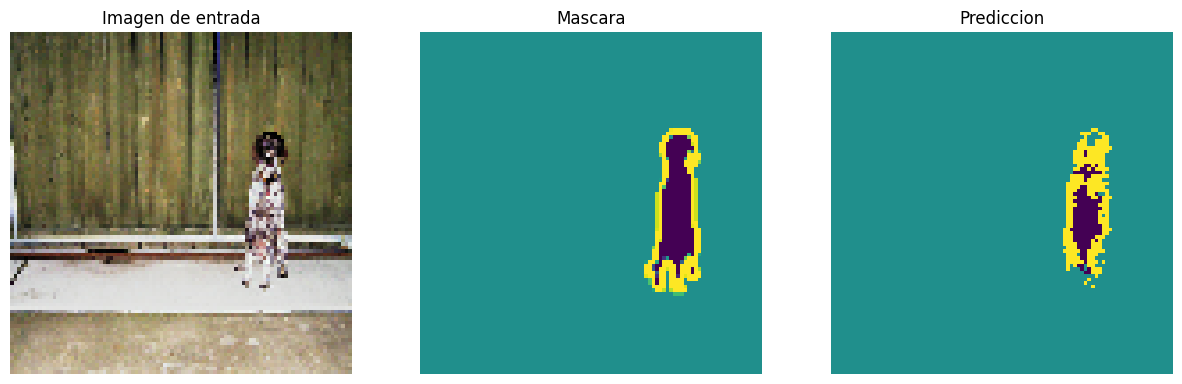


Sample Prediction after epoch 23

57/57 [==============================] - 4s 69ms/step - loss: 0.2305 - accuracy: 0.9038 - val_loss: 0.3192 - val_accuracy: 0.8722
Epoch 24/50
1/1 [==============================] - 0s 104ms/steposs: 0.2274 - accuracy: 0.90


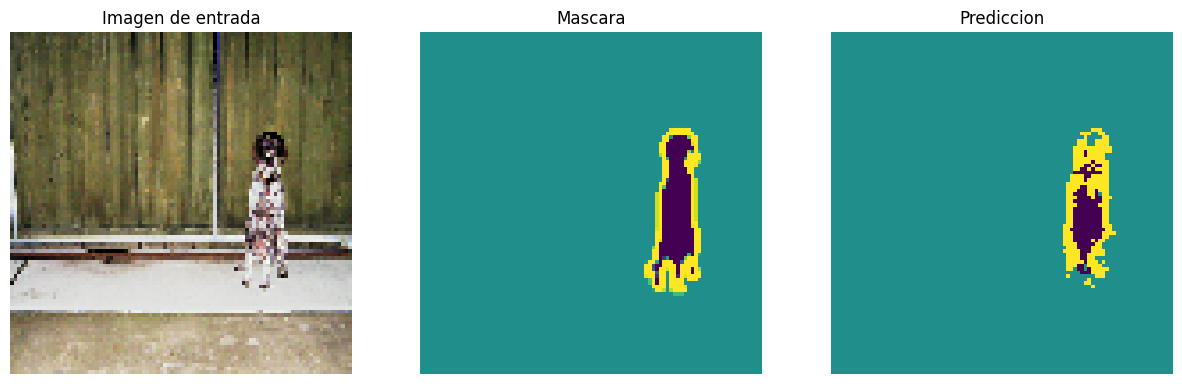


Sample Prediction after epoch 24

57/57 [==============================] - 4s 67ms/step - loss: 0.2274 - accuracy: 0.9048 - val_loss: 0.3167 - val_accuracy: 0.8739
Epoch 25/50
1/1 [==============================] - 0s 102ms/steposs: 0.2188 - accuracy: 0.90


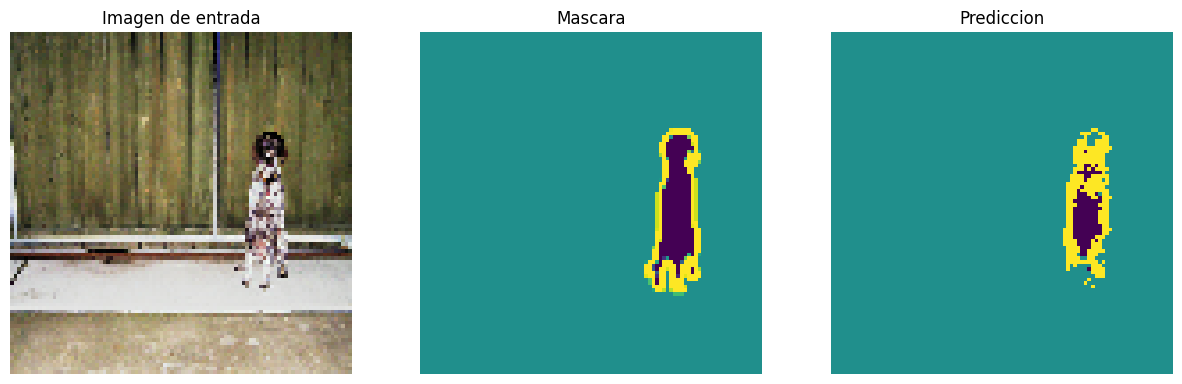


Sample Prediction after epoch 25

57/57 [==============================] - 4s 67ms/step - loss: 0.2188 - accuracy: 0.9081 - val_loss: 0.3214 - val_accuracy: 0.8719
Epoch 26/50
1/1 [==============================] - 0s 104ms/steposs: 0.2170 - accuracy: 0.90


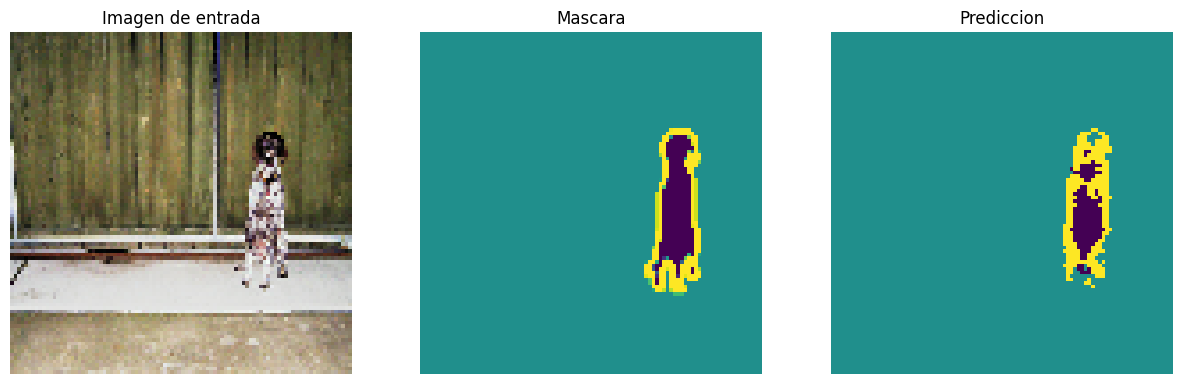


Sample Prediction after epoch 26

57/57 [==============================] - 4s 66ms/step - loss: 0.2170 - accuracy: 0.9085 - val_loss: 0.3251 - val_accuracy: 0.8712
Epoch 27/50
1/1 [==============================] - 0s 106ms/steposs: 0.2107 - accuracy: 0.91


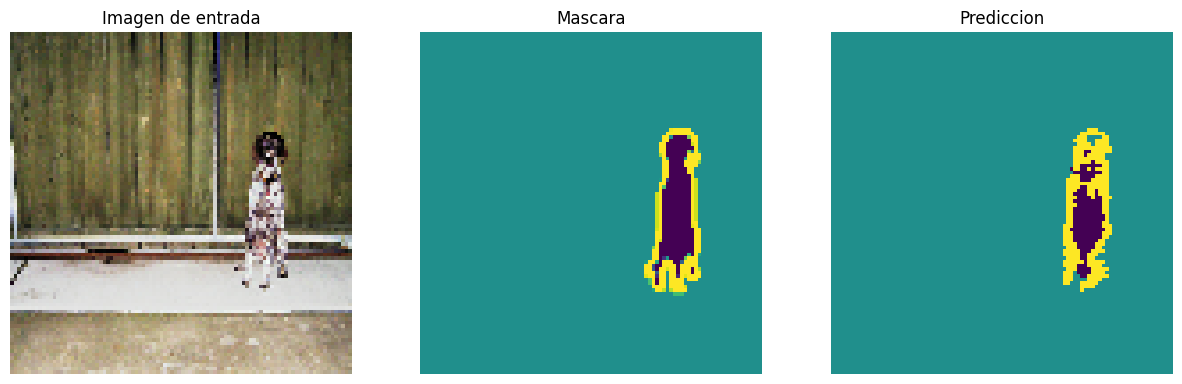


Sample Prediction after epoch 27

57/57 [==============================] - 4s 67ms/step - loss: 0.2107 - accuracy: 0.9110 - val_loss: 0.3174 - val_accuracy: 0.8753
Epoch 28/50
1/1 [==============================] - 0s 102ms/steposs: 0.2077 - accuracy: 0.91


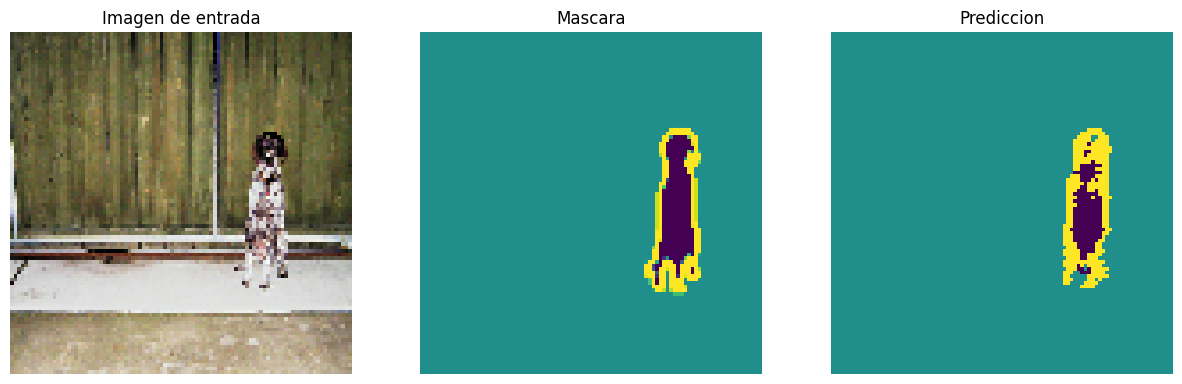


Sample Prediction after epoch 28

57/57 [==============================] - 4s 69ms/step - loss: 0.2077 - accuracy: 0.9119 - val_loss: 0.3188 - val_accuracy: 0.8745
Epoch 29/50
1/1 [==============================] - 0s 102ms/steposs: 0.2017 - accuracy: 0.91


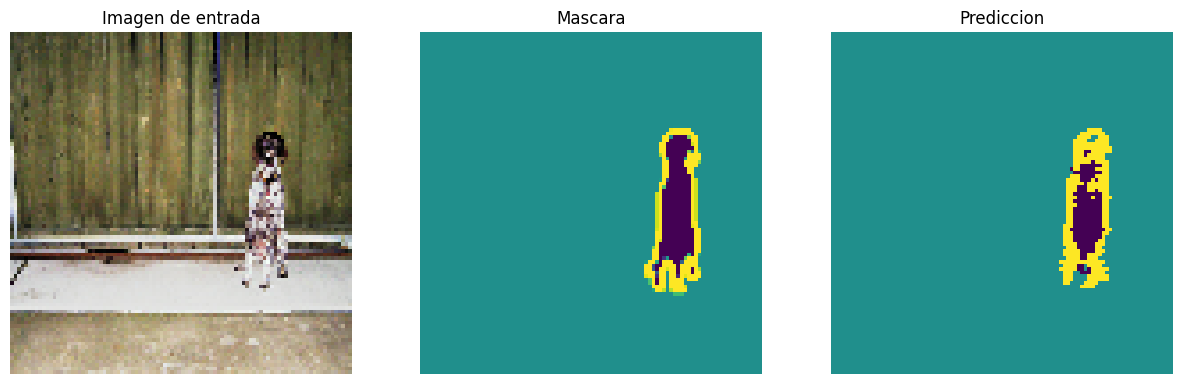


Sample Prediction after epoch 29

57/57 [==============================] - 4s 68ms/step - loss: 0.2017 - accuracy: 0.9143 - val_loss: 0.3184 - val_accuracy: 0.8758
Epoch 30/50
1/1 [==============================] - 0s 105ms/steposs: 0.1990 - accuracy: 0.91


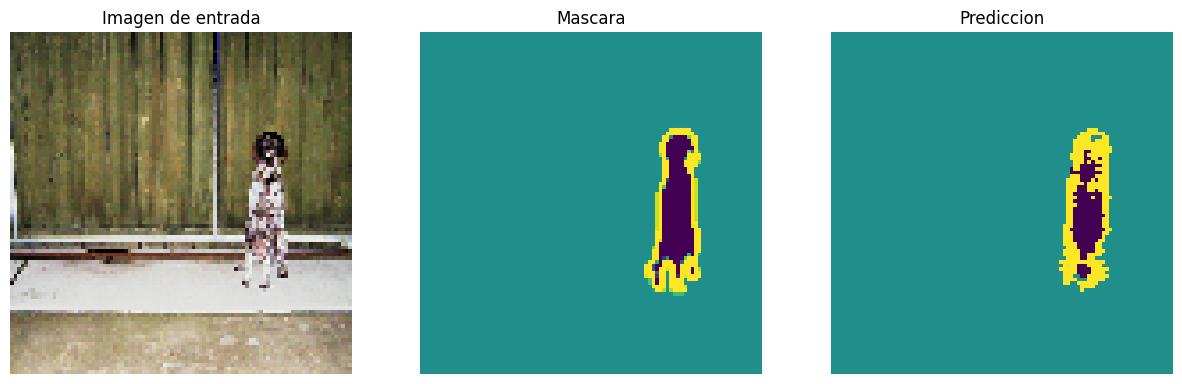


Sample Prediction after epoch 30

57/57 [==============================] - 4s 68ms/step - loss: 0.1990 - accuracy: 0.9151 - val_loss: 0.3255 - val_accuracy: 0.8734
Epoch 31/50
1/1 [==============================] - 0s 101ms/steposs: 0.1952 - accuracy: 0.91


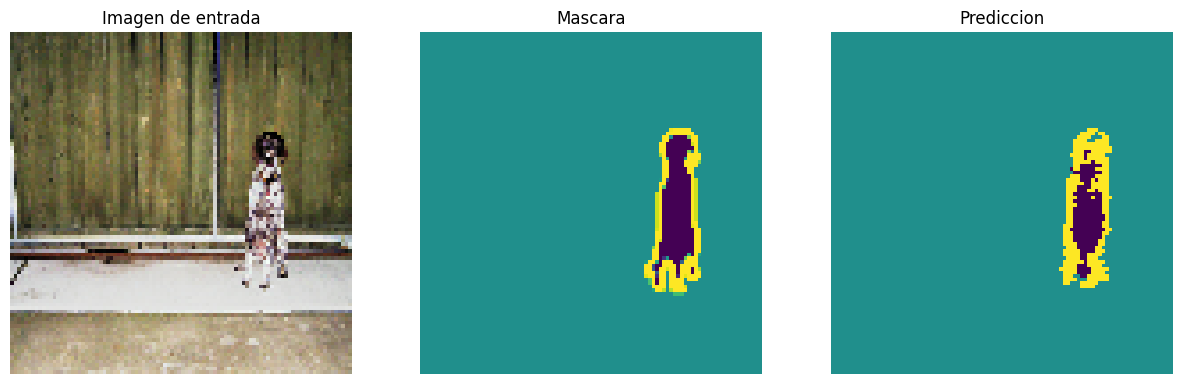


Sample Prediction after epoch 31

57/57 [==============================] - 4s 68ms/step - loss: 0.1952 - accuracy: 0.9166 - val_loss: 0.3264 - val_accuracy: 0.8739
Epoch 32/50
1/1 [==============================] - 0s 98ms/steploss: 0.1896 - accuracy: 0.91


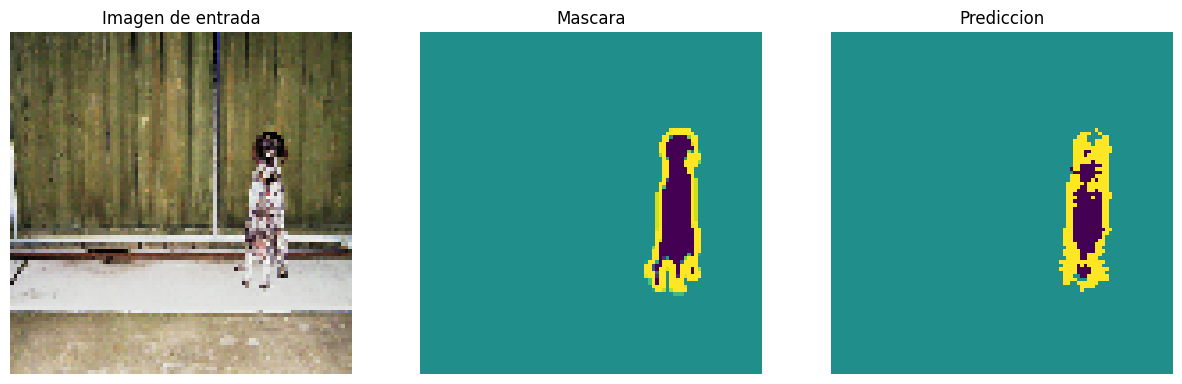


Sample Prediction after epoch 32

57/57 [==============================] - 4s 68ms/step - loss: 0.1896 - accuracy: 0.9186 - val_loss: 0.3329 - val_accuracy: 0.8715
Epoch 33/50
1/1 [==============================] - 0s 104ms/steposs: 0.1865 - accuracy: 0.92


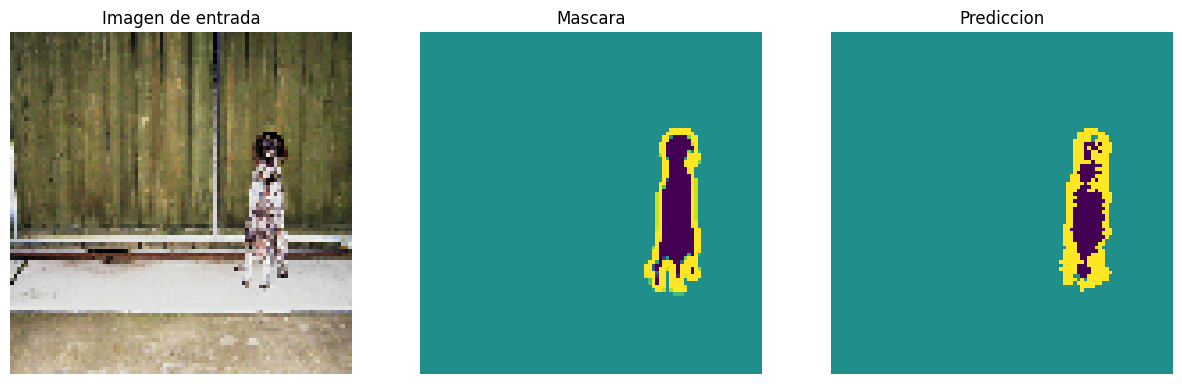


Sample Prediction after epoch 33

57/57 [==============================] - 4s 68ms/step - loss: 0.1866 - accuracy: 0.9200 - val_loss: 0.3283 - val_accuracy: 0.8745
Epoch 34/50
1/1 [==============================] - 0s 97ms/steploss: 0.1831 - accuracy: 0.92


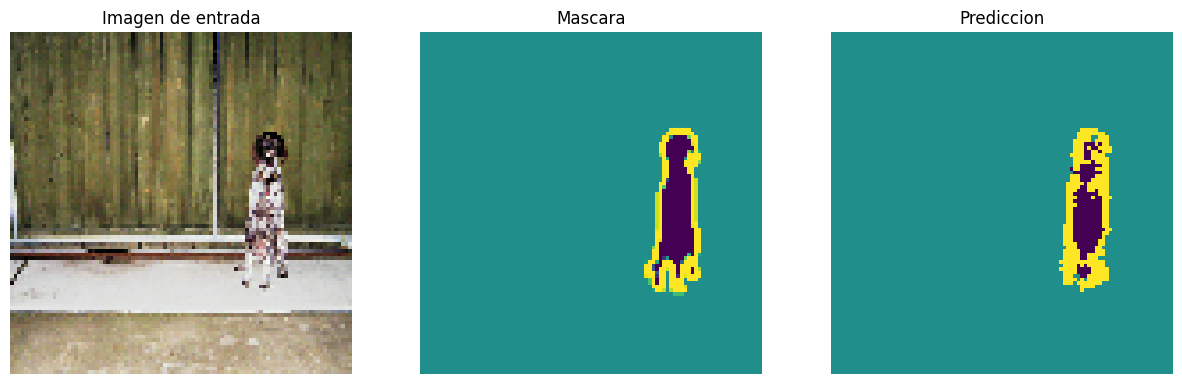


Sample Prediction after epoch 34

57/57 [==============================] - 4s 67ms/step - loss: 0.1831 - accuracy: 0.9213 - val_loss: 0.3324 - val_accuracy: 0.8729
Epoch 35/50
1/1 [==============================] - 0s 98ms/steploss: 0.1800 - accuracy: 0.92


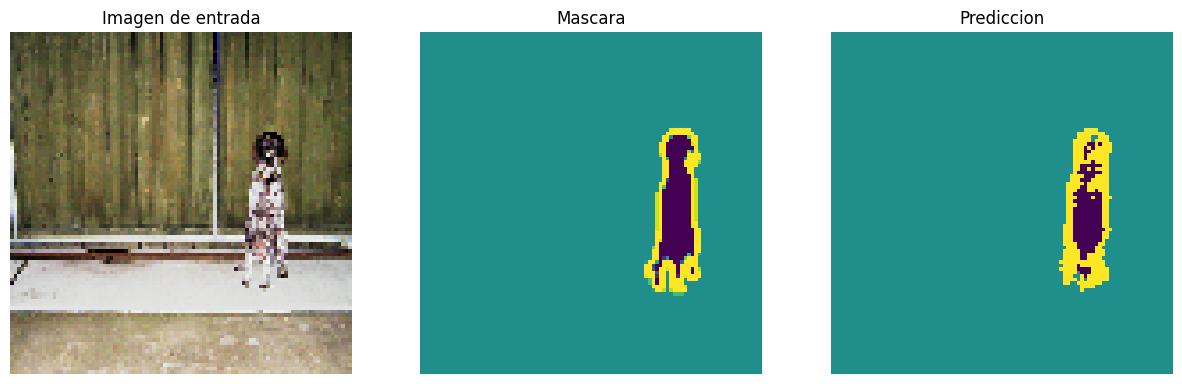


Sample Prediction after epoch 35

57/57 [==============================] - 4s 68ms/step - loss: 0.1800 - accuracy: 0.9222 - val_loss: 0.3348 - val_accuracy: 0.8724
Epoch 36/50
1/1 [==============================] - 0s 99ms/steploss: 0.1756 - accuracy: 0.92


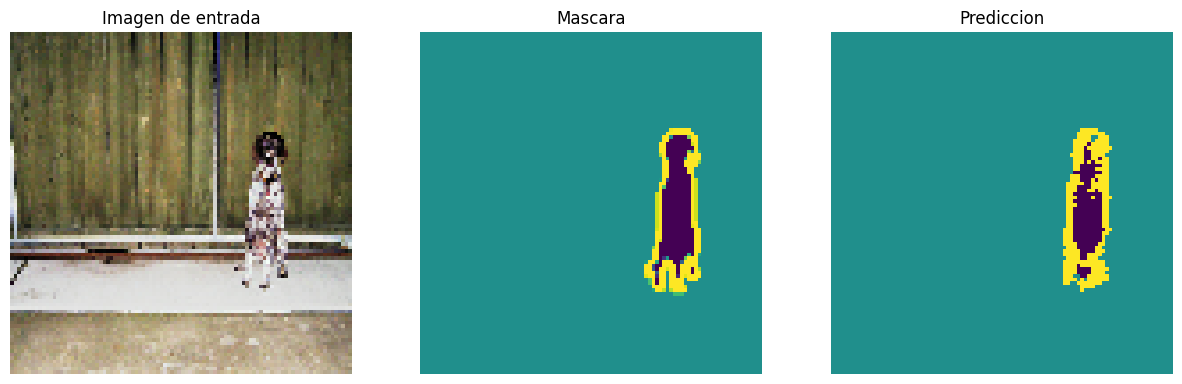


Sample Prediction after epoch 36

57/57 [==============================] - 4s 68ms/step - loss: 0.1756 - accuracy: 0.9242 - val_loss: 0.3463 - val_accuracy: 0.8688
Epoch 37/50
1/1 [==============================] - 0s 97ms/steploss: 0.1729 - accuracy: 0.92


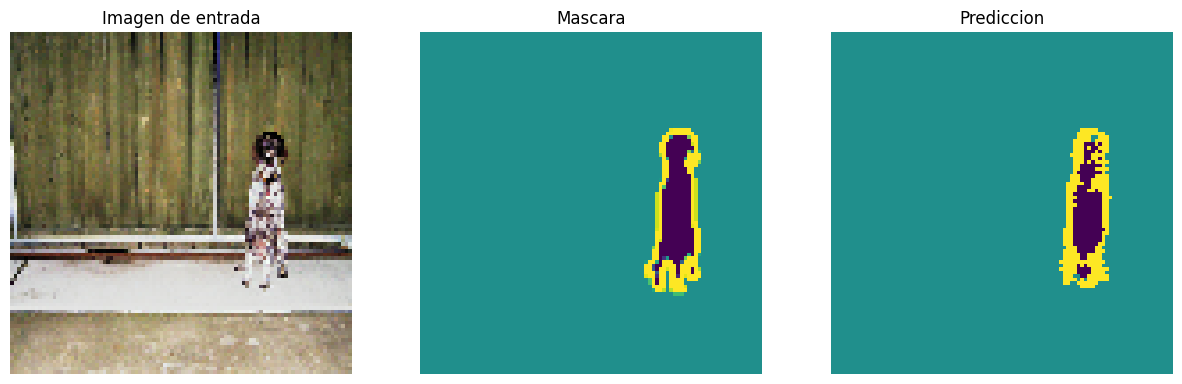


Sample Prediction after epoch 37

57/57 [==============================] - 4s 69ms/step - loss: 0.1729 - accuracy: 0.9251 - val_loss: 0.3445 - val_accuracy: 0.8710
Epoch 38/50
1/1 [==============================] - 0s 96ms/steploss: 0.1706 - accuracy: 0.92


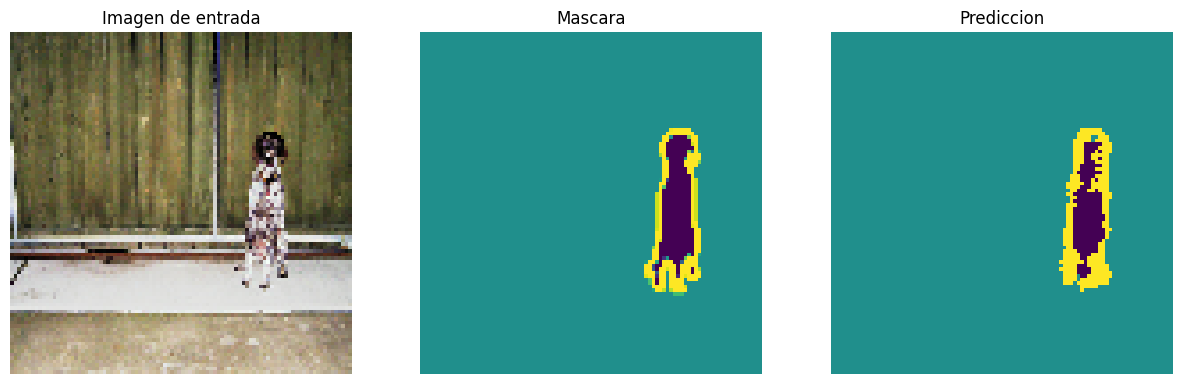


Sample Prediction after epoch 38

57/57 [==============================] - 4s 68ms/step - loss: 0.1706 - accuracy: 0.9258 - val_loss: 0.3415 - val_accuracy: 0.8717
Epoch 39/50
1/1 [==============================] - 0s 100ms/steposs: 0.1659 - accuracy: 0.92


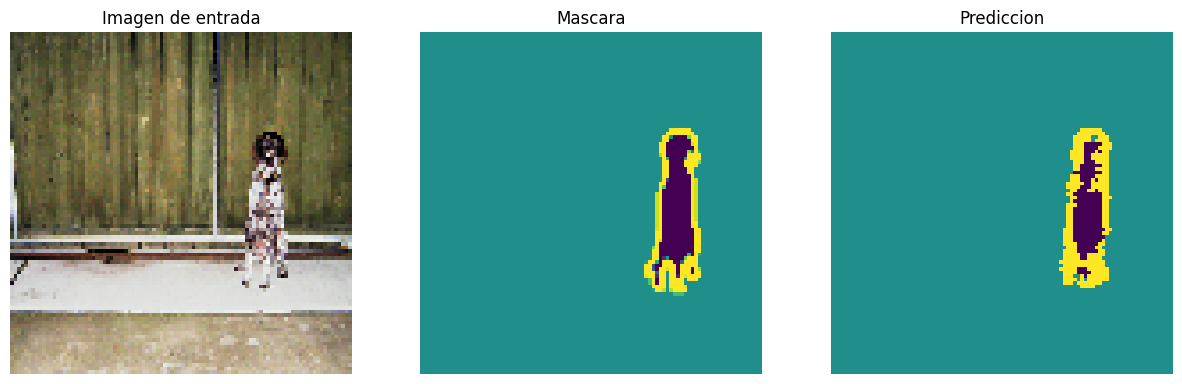


Sample Prediction after epoch 39

57/57 [==============================] - 4s 68ms/step - loss: 0.1659 - accuracy: 0.9279 - val_loss: 0.3497 - val_accuracy: 0.8698
Epoch 40/50
1/1 [==============================] - 0s 105ms/steposs: 0.1645 - accuracy: 0.92


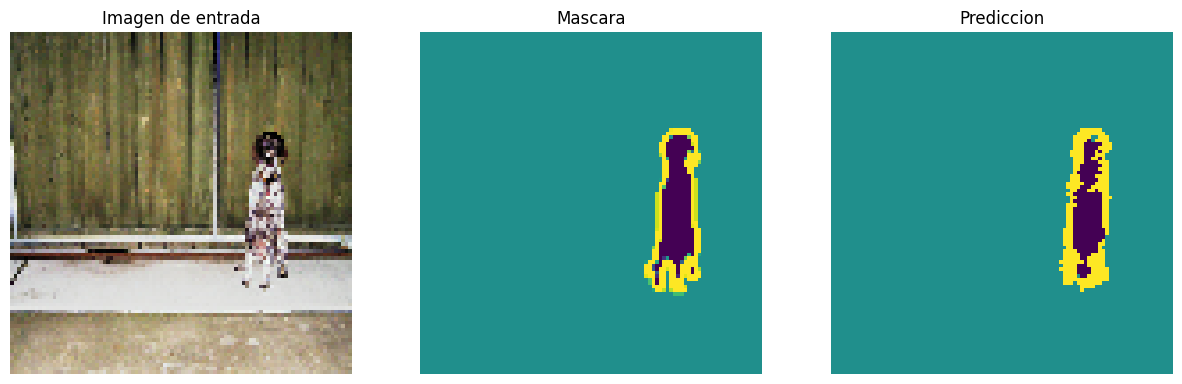


Sample Prediction after epoch 40

57/57 [==============================] - 4s 72ms/step - loss: 0.1645 - accuracy: 0.9283 - val_loss: 0.3517 - val_accuracy: 0.8706
Epoch 41/50
1/1 [==============================] - 0s 114ms/steposs: 0.1615 - accuracy: 0.92


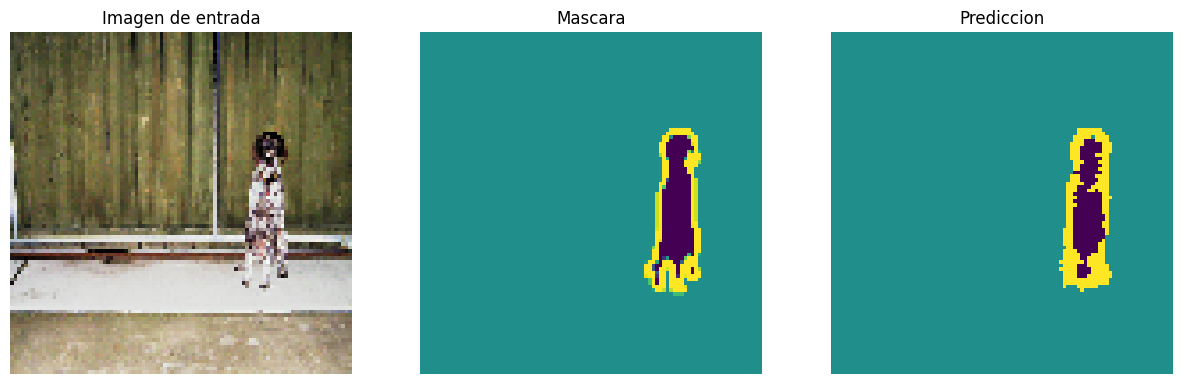


Sample Prediction after epoch 41

57/57 [==============================] - 4s 68ms/step - loss: 0.1615 - accuracy: 0.9294 - val_loss: 0.3478 - val_accuracy: 0.8722
Epoch 42/50
1/1 [==============================] - 0s 99ms/steploss: 0.1591 - accuracy: 0.93


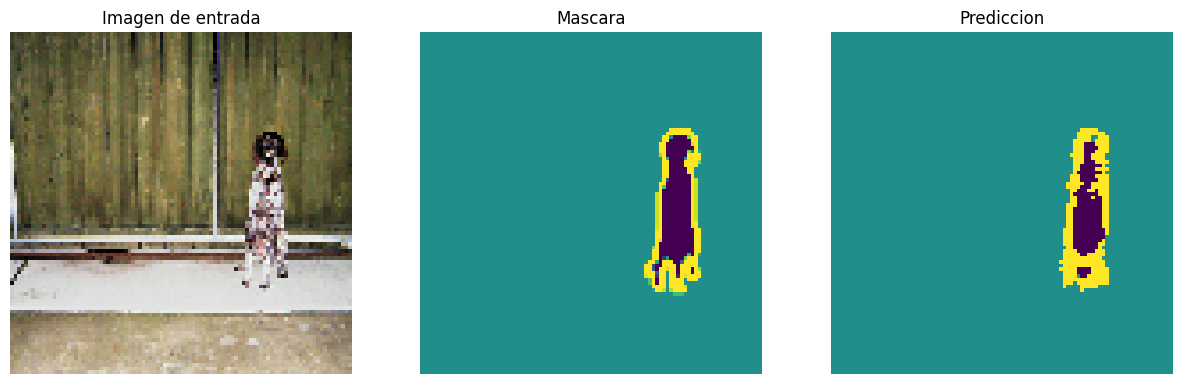


Sample Prediction after epoch 42

57/57 [==============================] - 4s 66ms/step - loss: 0.1591 - accuracy: 0.9306 - val_loss: 0.3568 - val_accuracy: 0.8695
Epoch 43/50
1/1 [==============================] - 0s 105ms/steposs: 0.1569 - accuracy: 0.93


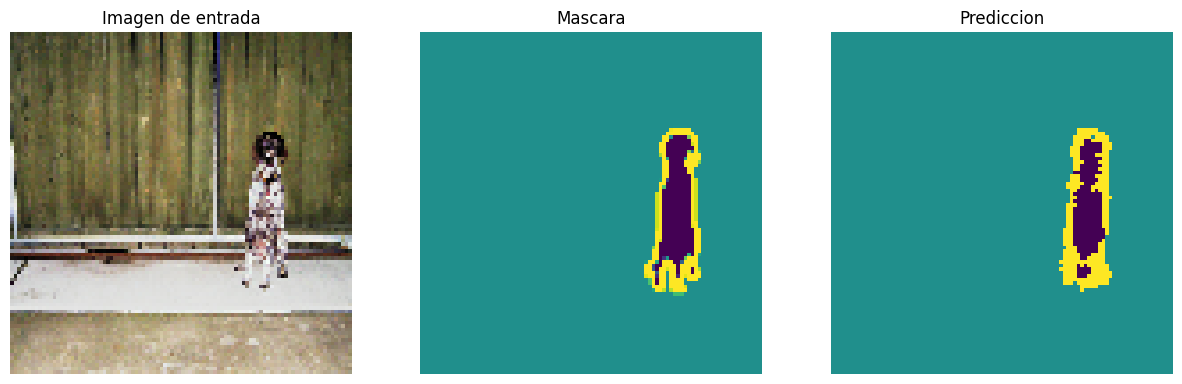


Sample Prediction after epoch 43

57/57 [==============================] - 4s 68ms/step - loss: 0.1569 - accuracy: 0.9311 - val_loss: 0.3577 - val_accuracy: 0.8709
Epoch 44/50
1/1 [==============================] - 0s 103ms/steposs: 0.1542 - accuracy: 0.93


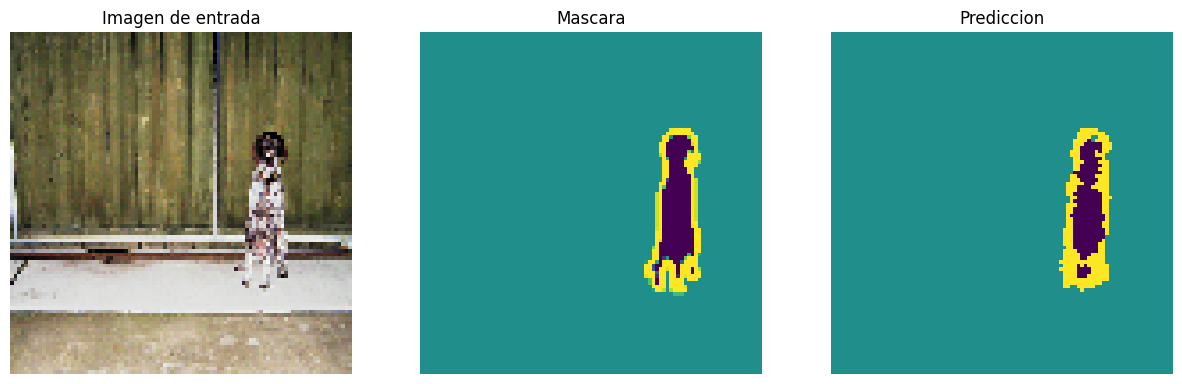


Sample Prediction after epoch 44

57/57 [==============================] - 4s 69ms/step - loss: 0.1542 - accuracy: 0.9324 - val_loss: 0.3626 - val_accuracy: 0.8692
Epoch 45/50
1/1 [==============================] - 0s 110ms/steposs: 0.1512 - accuracy: 0.93


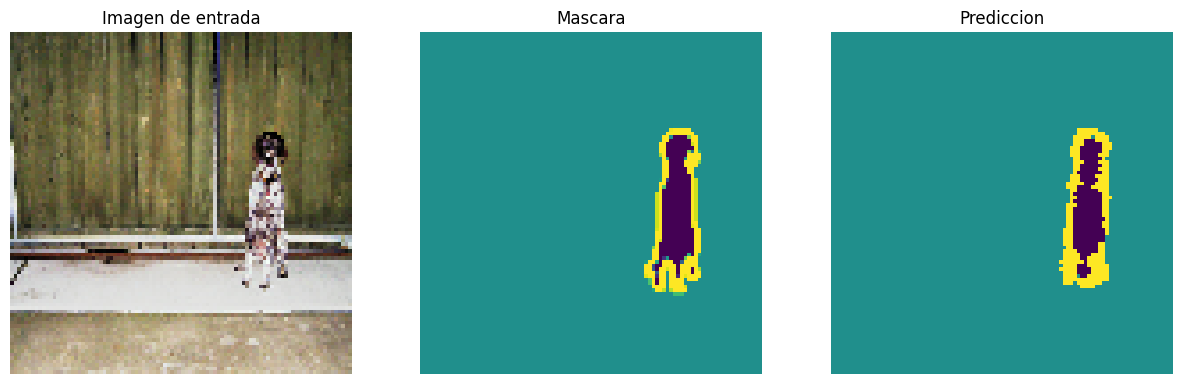


Sample Prediction after epoch 45

57/57 [==============================] - 4s 67ms/step - loss: 0.1512 - accuracy: 0.9335 - val_loss: 0.3663 - val_accuracy: 0.8692
Epoch 46/50
1/1 [==============================] - 0s 101ms/steposs: 0.1494 - accuracy: 0.93


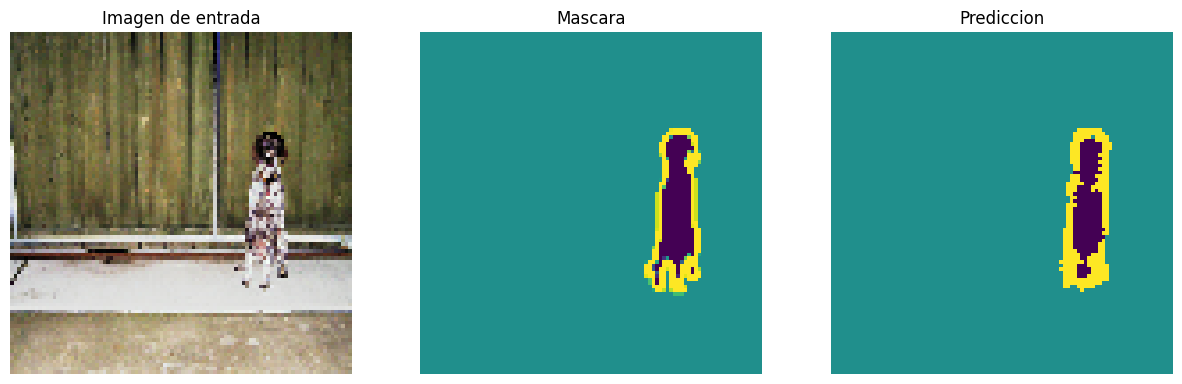


Sample Prediction after epoch 46

57/57 [==============================] - 4s 68ms/step - loss: 0.1494 - accuracy: 0.9342 - val_loss: 0.3754 - val_accuracy: 0.8670
Epoch 47/50
1/1 [==============================] - 0s 97ms/steploss: 0.1474 - accuracy: 0.93


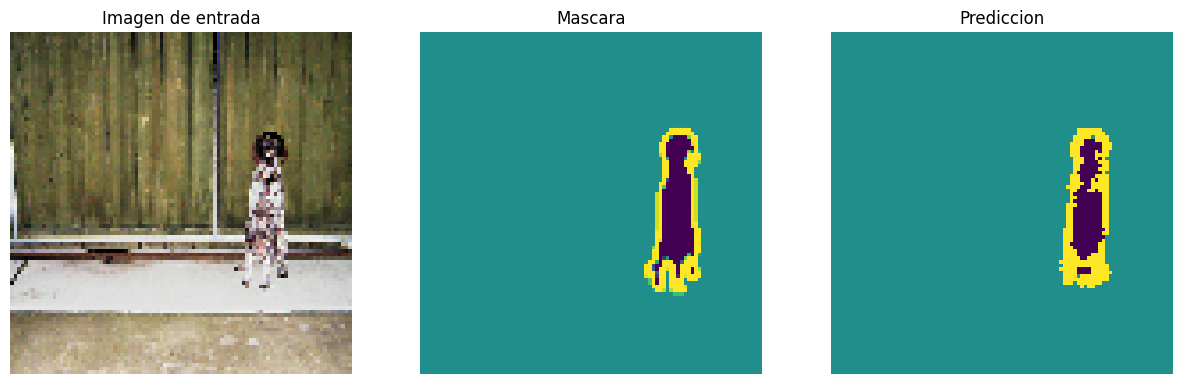


Sample Prediction after epoch 47

57/57 [==============================] - 4s 68ms/step - loss: 0.1474 - accuracy: 0.9350 - val_loss: 0.3701 - val_accuracy: 0.8692
Epoch 48/50
1/1 [==============================] - 0s 106ms/steposs: 0.1441 - accuracy: 0.93


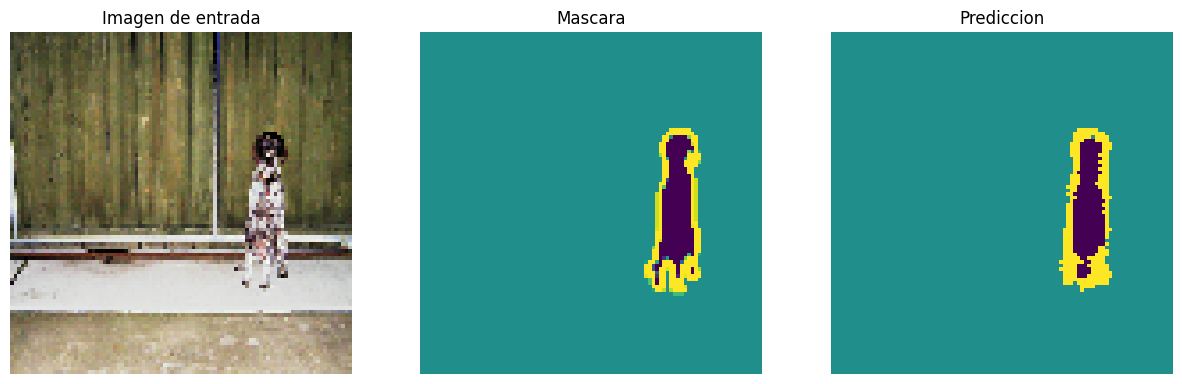


Sample Prediction after epoch 48

57/57 [==============================] - 4s 67ms/step - loss: 0.1441 - accuracy: 0.9364 - val_loss: 0.3710 - val_accuracy: 0.8701
Epoch 49/50
1/1 [==============================] - 0s 105ms/steposs: 0.1429 - accuracy: 0.93


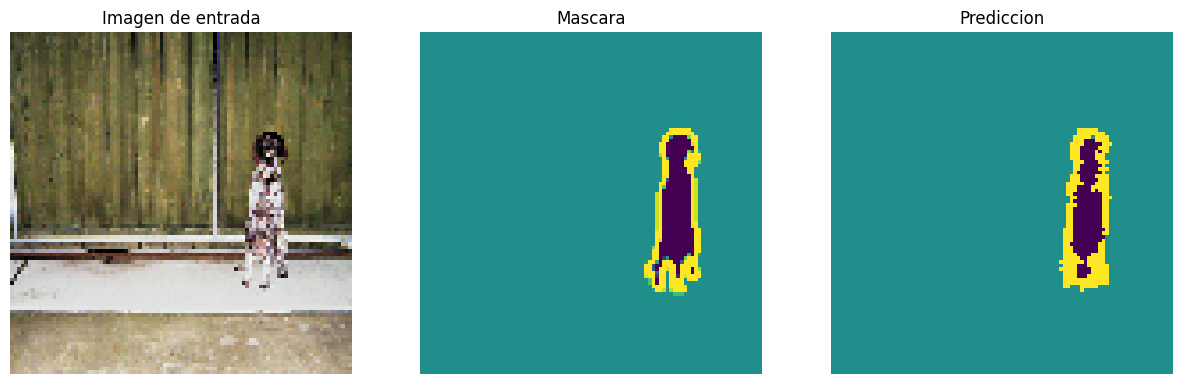


Sample Prediction after epoch 49

57/57 [==============================] - 4s 68ms/step - loss: 0.1429 - accuracy: 0.9368 - val_loss: 0.3760 - val_accuracy: 0.8683
Epoch 50/50
1/1 [==============================] - 0s 108ms/steposs: 0.1411 - accuracy: 0.93


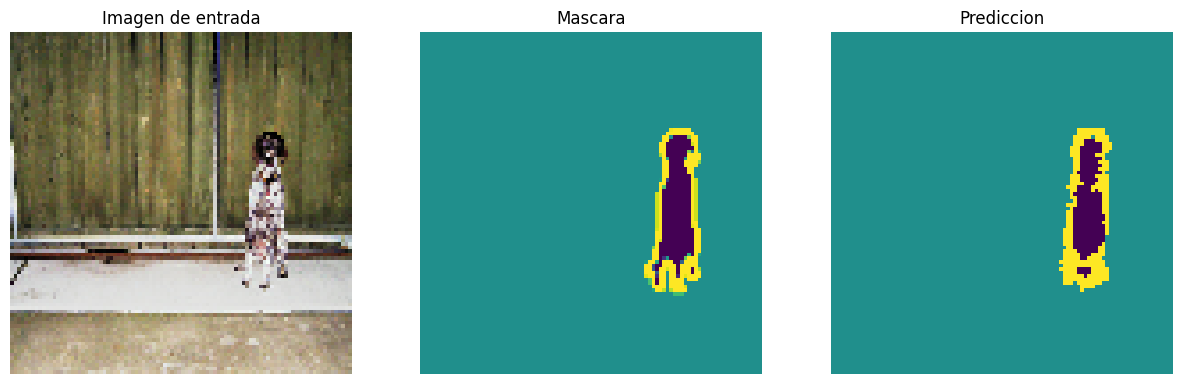


Sample Prediction after epoch 50

57/57 [==============================] - 4s 68ms/step - loss: 0.1411 - accuracy: 0.9375 - val_loss: 0.3842 - val_accuracy: 0.8674


In [54]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS, 
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

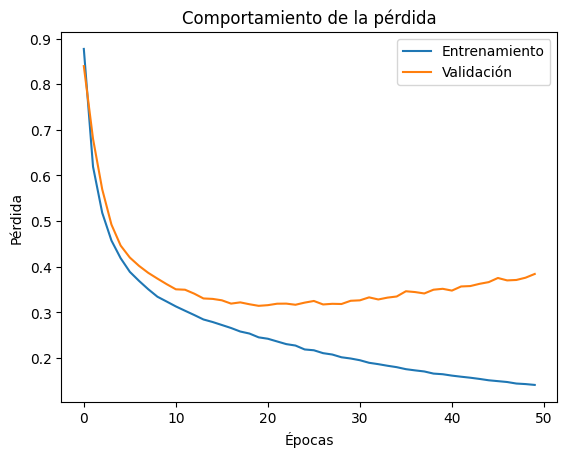

In [55]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Comportamiento de la pérdida")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.legend(["Entrenamiento", "Validación"], loc="best")
plt.show()

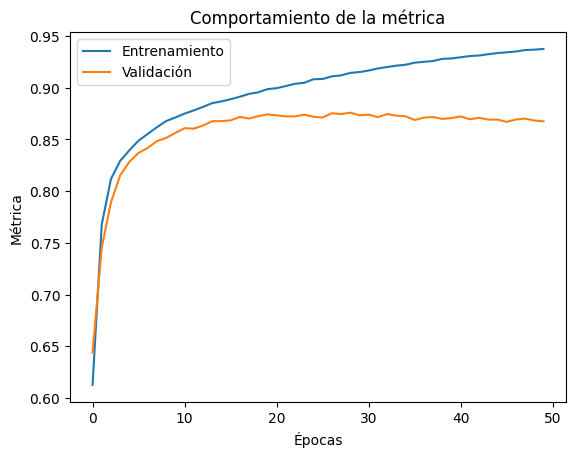

In [56]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Comportamiento de la métrica")
plt.ylabel("Métrica")
plt.xlabel("Épocas")
plt.legend(["Entrenamiento", "Validación"], loc="best")
plt.show()